In [1]:
import os
import glob
import numpy as np
import bottleneck as bn
import pandas as pd
import bootmedian as bm # This is a custom made module available at GitHub. https://github.com/Borlaff/bootmedian
import seaborn as sns

from tqdm import tqdm
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import Video
from reproject import reproject_interp
import sys
sys.path.append("/home/borlaff/NASA/SOFIA/MOHAWC/")
from mohawc import *

import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord 

nsimul = 100

sigma1=0.682689492137086 
sigma2=0.954499736103642 
sigma3=0.997300203936740 

legacy_wd="/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/"
os.chdir("/home/borlaff/NASA/SOFIA/LEGACY/WORK_ZONE/")

#####
# Galaxy constants
#####

# Centaurus A 
cenA_center = [201.365063, -43.019113]
cenA_pa = 114
cenA_dpa = 14
cenA_incl = 83
cenA_dincl = 6

# Circinus
circinus_center = [213.29130,-65.33926] # For, Koribalski, Jarrett et al. 2012
circinus_incl = 40 # For, Koribalski, Jarrett et al. 2012
circinus_dincl = 10
circinus_pa = 205 # For, Koribalski, Jarrett et al. 2012
circinus_dpa = 10

# NGC253 
ngc253_center = [11.888002, -25.288220]
ngc253_pa = 52
ngc253_dpa = 1
ngc253_incl = 78.3
ngc253_dincl = 1
ngc253_dist = 3.5
ngc253_ddist = 0.1

# M51 
m51_incl = 22.0
m51_dincl = 5.0
m51_pa = 7.0  
m51_dpa = 3.0
m51_nbins = 14
m51_center = [202.4698899, +47.1952002]

# M82 
m82_center = [148.969687, 69.679383]
m82_pa = 64
m82_dpa = 1
m82_incl = 76
m82_dincl = 1

# M83
m83_center = [204.253958, -29.865417]
m83_pa = 226 # Foyle et al. 2012 
m83_dpa = 5
m83_incl = 25 # Coyle 1981
m83_dincl = 5

# NGC1068
ngc1068_center = [40.669629, -0.013281]
ngc1068_pa = 360-286
ngc1068_dpa = 5 # Das et al. 2006
ngc1068_incl = 40 
ngc1068_dincl = 3

# NGC1097
ngc1097_center = [41.579375, -30.274889] # Sheth et al 2010
ngc1097_pa = 133.0
ngc1097_dpa = 0.1
ngc1097_incl =  41.7
ngc1097_dincl =  0.6

# NGC2146
ngc2146_center = [94.657125, 78.357028]
ngc2146_pa = 140 # Sanchez-Portal+ 2000
ngc2146_dpa = 2 
ngc2146_incl = 63
ngc2146_dincl = 2

# NGC3627
ngc3627_center = [170.062351, 12.991538]
ngc3627_pa = 176
ngc3627_dpa = 1
ngc3627_incl = 52
ngc3627_dincl = 1

# NGC4736 
ngc4736_center = [192.721088, 41.120458]
ngc4736_pa = 292
ngc4736_dpa = 2 
ngc4736_incl = 36
ngc4736_dincl = 7
ngc4736_dist = 5.3
ngc4736_ddist = 0.1

# NGC4826
ngc4826_center = [194.181837, 21.682970]
ngc4826_pa = 125
ngc4826_dpa = 5
ngc4826_incl = 65
ngc4826_dincl = 5

# NGC6946
ngc6946_center = [308.718015, 60.153915]
ngc6946_pa = 239
ngc6946_dpa = 1 # Kuno+2007
ngc6946_incl = 38.4 # Kuno+2007
ngc6946_dincl = 3.0 # Kuno+2007

# NGC7331
ngc7331_center = [339.266724, 34.415519]
ngc7331_pa = 165
ngc7331_dpa = 1.2 
ngc7331_incl = 78.1
ngc7331_dincl = 2.7




# For the pitch angle of the baryonic spiral arms - Patrikeev et al (2006)
# For the galaxy centre, inclination and position angle - Colombo et al (2014).
# For the corotation radii of the bar/arm features and their pattern speeds - Querejeta et al (2016).
# PA= (173±3)◦) and inclination (i= (22±5)◦

# SNR_p >=2, SNR_pi >=2, p<=30, y SNR_I >= 50, excepto para M82, NGC 253 y NGC 2146, con SNR_I >= 80.

#SNR_pol_limit_HAWC = 0
#SNR_polflux_limit_HAWC = 3
#SNR_int_limit_HAWC = 20 # np.sqrt(SNR_pol_limit_HAWC)/(0.05)
p_limit = 20

save_temp=False


#%%%%%%%%%%%%%%%%%%%%%%%%%# 
hr_M51 = 84.203 # arcsec # Salo et al. 2015, S4G, expdisk
hr_M83 = 106.752 # arcsec # Salo et al. 2015, S4G, expdisk
hr_NGC3627 = 53.954 # arcsec # Salo et al. 2015, S4G, expdisk
hr_NGC4736 = 253.870 # arcsec # 50.466| 
hr_NGC6946 = 2.97/(5.545*1000)*180/np.pi*60*60 # arcsec to, from 2MASS 3.6um de Blok et al. 2008 kpc 
hr_NGC7331 = 54.6 # arcsec , fitted from Prada et al. 1996. I band, 26.58642 # k-band. 

Astrobox v.1.0
Astronomy Imaging Tool Box - A box of usual tools for astronomical imaging processing
Author: Alejandro S. Borlaff - NASA Ames Research Center - a.s.borlaff@nasa.gov / asborlaff@gmail.com


In [2]:
def get_pixscale(HAWC_image):
    hawc_fits = fits.open(HAWC_image)
    pixscale =  np.abs(hawc_fits[1].header["CDELT1"])*60.*60. # arcsec/pix
    return(pixscale)

In [3]:
#1    1-  4  I4    ---        Seq    [1/2352] Running sequence number
#2    6- 15  A10   ---        Name   Galaxy name
#3   17- 24  A8    ---        Mod    Type of final decomposition model (1)
#4   26- 31  A6    ---        ---    [NCOMP=]
#5   32  I1    ---        Nc     [1/4] Number of components in the model (1-4)
#6   34- 41  A8    ---        ---    [quality=]
#7       42  I1    ---        Q      [3/5] Quality flag, 5=most reliable (2)
#8   44- 50  A7    ---        C      Phsical interpretation of the component (1)
#9   52- 59  A8    ---        Fn     The GALFIT function used for the component (sersic, edgedisk, expdisk, ferrer2 or psf)
#10  61- 65  F5.3  ---        f1     [0.006/1]? "sersic" fraction of the total model flux
#11  67- 72  F6.3  mag        mag1   [7/19.4]? "sersic" total 3.6um AB magnitude
#12  74- 78  F5.3  ---        q1     [0.1/1]? "sersic" axis ratio (3)
#13  80- 86  F7.3  deg        PA1    [0.08/180]? "sersic" position angle (3)
#14  88- 94  F7.3  arcsec     Re     [0.004/430]? "sersic" effective radius (R_e_)
#15  96-101  F6.3  ---        n      [0.01/20]? "sersic" parameter n
#16 103-107  F5.3  ---        f2     [0.02/1]? "edgedisk" fraction of the total model flux
#17 109-114  F6.3 mag/arcsec2 mu02   [11.8/24.6]? "edgedisk" central surface face-on brightness ({mu}_0_)
#18 116-122  F7.3  deg        PA2    [-90/90]? "edgedisk"  PA
#19 124-130  F7.3  arcsec     hr2    [1/153]? "edgedisk" exponential scale length (h_r_)
#20 132-137  F6.3  arcsec     hz2    [0.003/39]? "edgedisk" z-scale h_z_
#21 139-143  F5.3  ---        f3     [0.02/1]? "expdisk" fraction of the total model flux
#22 145-150  F6.3  mag        mag3   [6.5/18.1]? "expdisk" total 3.6um AB magnitude
#23 152-156  F5.3  ---        q3     [0.1/1]? "expdisk" axis ratio (3)
#24 158-164  F7.3  deg        PA3    [-90/90]? "expdisk" position angle (3)
#25 166-172  F7.3  arcsec     hr3    [0.7/332]? "expdisk" exponential scale length (h_r_)
#26 174-179  F6.3 mag/arcsec2 mu03   [16.4/25.3]? "expdisk" central surface face-on brightness ({mu}_0_)



In [4]:

data = ascii.read("/home/borlaff/NASA/SOFIA/LEGACY/CORE/table7.dat", delimiter='|')

print(data[data["col2"] == "NGC5194"])
print(data[data["col2"] == "NGC5236"])
print(data[data["col2"] == "NGC3627"])
print(data[data["col2"] == "NGC4736"]) # NGC 4736 1.61 13.29 0.40 3.30 1.11 9.14 0.69 https://arxiv.org/pdf/0907.4884.pdf
print(data[data["col2"] == "NGC6946"])
print(data[data["col2"] == "NGC7331"])
print(data[data["col2"] == "NGC1068"])

# NGC 1068 0.59 8.68 0.35 5.09 0.89 13.11 1.51
# NGC 4736 1.61 13.29 0.40 3.30 1.11 9.14 0.69

col1   col2  col3   col4     col5   col6 ... col26 col27 col28 col29 col30 col31
---- ------- ---- ------- --------- ---- ... ----- ----- ----- ----- ----- -----
1376 NGC5194  _bd NCOMP=2 quality=5    B ...    --    --    --    --    --    --
1376 NGC5194  _bd NCOMP=2 quality=5    D ...    --    --    --    --    --    --
col1   col2    col3    col4     col5   col6 ... col27 col28  col29  col30 col31
---- ------- ------- ------- --------- ---- ... ----- ------ ------ ----- -----
1383 NGC5236 _bdbarf NCOMP=3 quality=5    B ...    --     --     --    --    --
1383 NGC5236 _bdbarf NCOMP=3 quality=5    D ...    --     --     --    --    --
1383 NGC5236 _bdbarf NCOMP=3 quality=5  BAR ... 0.373 45.608 101.25    --    --
col1   col2   col3    col4     col5   col6 ... col27  col28   col29  col30 col31
---- ------- ------ ------- --------- ---- ... ----- ------- ------- ----- -----
 907 NGC3627 _bdbar NCOMP=3 quality=5    B ...    --      --      --    --    --
 907 NGC3627 _bdbar NCOMP=3 quali

In [5]:
SNR_galaxies = ascii.read("/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/galaxies.lst", delimiter=',')


In [6]:
# Matching the catalog from  https://cdsarc.cds.unistra.fr/ftp/J/MNRAS/406/1595/ReadMe
data = ascii.read("/home/borlaff/NASA/SOFIA/LEGACY/CORE/sdssh.dat", delimiter=' ')

ra1 = np.array([m51_center[0], m83_center[0], ngc3627_center[0], ngc4736_center[0],
                ngc6946_center[0], ngc7331_center[0], ngc1068_center[0]])

dec1 = np.array([m51_center[1], m83_center[1], ngc3627_center[1], ngc4736_center[1],
                 ngc6946_center[1], ngc7331_center[1], ngc1068_center[1]])
c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
catalog = SkyCoord(ra=data["col1"]*u.degree, dec=data["col2"]*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

In [7]:
d2d

<Angle [ 0.48785968, 26.32655264,  0.3019454 ,  0.27232162, 21.84092656,
        19.6424058 ,  0.45793242] deg>

(array([3.000e+00, 7.000e+00, 2.100e+01, 7.900e+01, 1.400e+02, 3.570e+02,
        6.360e+02, 9.850e+02, 1.306e+03, 1.525e+03, 1.482e+03, 1.282e+03,
        9.250e+02, 6.650e+02, 3.360e+02, 1.680e+02, 5.700e+01, 2.300e+01,
        2.000e+00, 1.000e+00]),
 array([-2.87421594, -2.48553219, -2.09684844, -1.70816469, -1.31948094,
        -0.93079719, -0.54211344, -0.1534297 ,  0.23525405,  0.6239378 ,
         1.01262155,  1.4013053 ,  1.78998905,  2.1786728 ,  2.56735654,
         2.95604029,  3.34472404,  3.73340779,  4.12209154,  4.51077529,
         4.89945904]),
 <BarContainer object of 20 artists>)

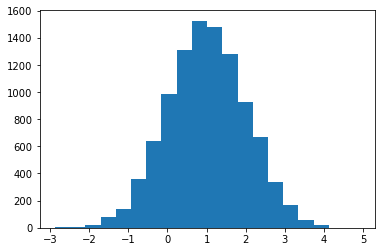

In [8]:
# Test histogram 
a = np.random.normal(1,1,(100,100))
plt.hist(a.ravel(), bins=20)

In [9]:
# List all the input files 
HAWC_obs = sorted(glob.glob(legacy_wd + "*.fits"))
HAWC_obs

['/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/CentaurusA_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/Circinus_A.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/Circinus_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/Circinus_E.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M51_D.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M82_A.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M82_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M82_D.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M82_E.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M83_D.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/NGC1068_A.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/NGC1068_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/NGC1097_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/NGC1097_D.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/

In [10]:
SNR_galaxies

name,band,object,filename,SNRp_cut,SNRpi_cut,p_cut,SNRI_cut,colors,width,height,scale,scalebar,vmin_PI,vmax_PI,steps_PI,vmin_I,vmax_I
str11,int64,str10,str28,float64,float64,int64,int64,int64,int64,int64,float64,float64,int64,float64,int64,float64,float64
Centaurus A,89,CenA,../../Data/CentaurusA_C.fits,0.0,3.0,20,20,0,250,250,16.42,1.0,0,2.0,1,0.003,0.2
Circinus,53,Circinus_A,../../Data/Circinus_A.fits,0.0,3.0,20,20,2,50,50,20.17,0.5,0,40.0,1,0.06,0.8
Circinus,89,Circinus_C,../../Data/Circinus_C.fits,0.0,3.0,20,20,2,150,150,20.17,1.0,0,2.0,5,0.001,0.5
Circinus,214,Circinus_E,../../Data/Circinus_E.fits,0.0,3.0,20,20,2,250,350,20.17,1.0,0,1.0,1,0.0005,0.1
M51,154,M51,../../Data/M51_D.fits,0.0,3.0,20,20,1,350,350,41.21,1.0,0,0.3,1,0.0005,0.05
M82,53,M82_A,../../Data/M82_A.fits,0.0,3.0,20,80,3,100,100,18.49,1.0,0,20.0,5,0.02,0.6
M82,89,M82_C,../../Data/M82_C.fits,0.0,3.0,20,80,3,150,150,18.49,1.0,0,8.0,5,0.01,0.3
M82,154,M82_D,../../Data/M82_D.fits,0.0,3.0,20,20,3,250,250,18.49,1.0,0,1.5,5,0.001,1.0
M82,214,M82_E,../../Data/M82_E.fits,0.0,3.0,20,20,3,300,300,18.49,1.0,0,0.8,5,0.001,0.2


SNR pol limit is 0, switching to inf
41.21622553584378 32.82906380480039


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/19 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/68 [00:00<?, ?it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  2  5  8 11 14 17 19 22 25 28 31 34 36 39 42 45 48 51 54]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    1.416203   0.868255   1.975323   1.722086   1.139688   1.947951   
1    3.724984   2.201681   4.820055   4.147770   3.472250   4.768014   
2    6.625964   5.288723   7.525051   6.899061   6.343436   7.269099   
3    9.589226   8.211289  10.454527   9.771822   9.355014  10.246471   
4   12.584402  11.207677  13.718509  12.762681  12.340055  13.121906   
5   15.575638  14.824567  16.198530  15.828290  15.383289  15.952431   
6   18.027133  17.472683  18.525920  18.166523  17.895395  18.399494   
7   20.561576  19.869459  21.763502  20.756216  20.402921  21.505966   
8   23.548116  23.145045  24.227962  23.747698  23.391018  24.026237   
9   26.543426  25.983854  27.015140  26.672520  26.366729  26.940992   
10  29.516555  28.395956  30.060832  29.643162  29.381997  29.929893   
11  32.539295 

/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 68/68 [00:01<00:00, 40.16it/s]


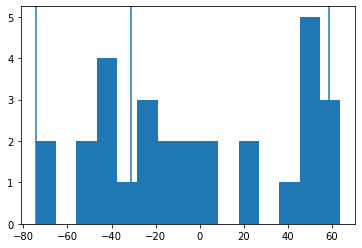

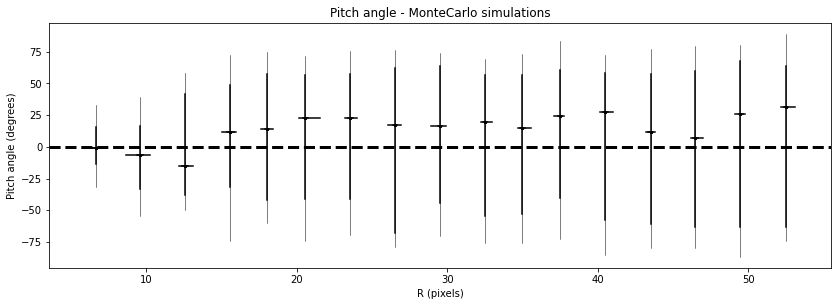

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       2   6.625964   5.288723   7.525051   6.899061   6.343436   7.269099   
1       3   9.589226   8.211289  10.454527   9.771822   9.355014  10.246471   
2       4  12.584402  11.207677  13.718509  12.762681  12.340055  13.121906   
3       5  15.575638  14.824567  16.198530  15.828290  15.383289  15.952431   
4       6  18.027133  17.472683  18.525920  18.166523  17.895395  18.399494   
5       7  20.561576  19.869459  21.763502  20.756216  20.402921  21.505966   
6       8  23.548116  23.145045  24.227962  23.747698  23.391018  24.026237   
7       9  26.543426  25.983854  27.015140  26.672520  26.366729  26.940992   
8      10  29.516555  28.395956  30.060832  29.643162  29.381997  29.929893   
9      11  32.539295  32.028664  33.636052  32.671105  32.362278  32.972535   
10     12  34.991921  34.663181  35.805066  35.197936  34.862606  35.574089   
11     13  37.507932  36.492040  38.099236  37.64454

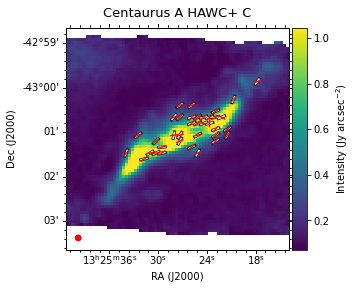

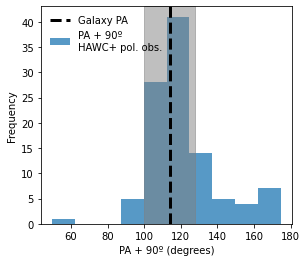

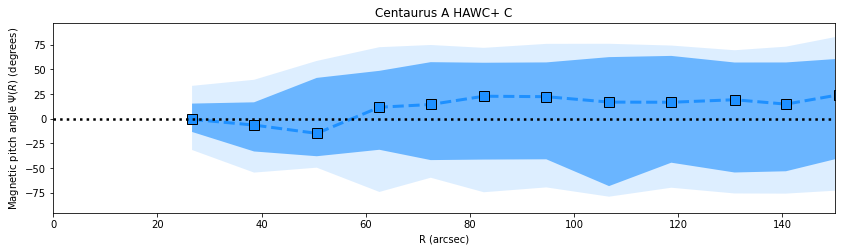

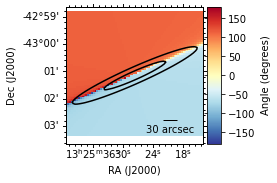

In [11]:
# Centaurus A
image_input=legacy_wd+"CentaurusA_C.fits"
name="CenA_C_"

source_center = cenA_center
PA = cenA_pa
dPA = cenA_dpa
incl = cenA_incl
dincl = cenA_dincl
nbins = 20

plot_title = r'Centaurus A HAWC+ C'
max_radii = 150 

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "CenA"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


#cenA_profile
cenA_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                      PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                      SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                      SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                      plot_title=plot_title, profile_color="dodgerblue", max_radii=max_radii)



In [12]:
float(np.array([1]))

1.0

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
43.386780564210966 36.41683359476493


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/49 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 35%|███▍      | 17/49 [00:00<00:00, 162.91it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  1  2  3  4  5  7  8  9 10 11 13 14 15 16 17 19 20 21 22 23 25 26 27
 28 29 30 32 33 34 35 36 38 39 40 41 42 44 45 46 47 48 50 51 52 53 54 56
 57 58]


  0%|          | 0/78 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 10%|█         | 8/78 [00:00<00:01, 38.87it/s]

            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    0.748148   0.744790   0.750960   0.749539   0.746904   0.750772   
1    1.717496   1.682746   1.731135   1.726651   1.687824   1.730661   
2    2.683036   2.559802   2.698096   2.691899   2.617253   2.697062   
3    3.623306   3.513074   3.670070   3.651605   3.584031   3.665628   
4    4.554089   4.518492   4.591112   4.567630   4.536699   4.587389   
5    6.057191   5.974249   6.098569   6.080773   6.027294   6.093873   
6    7.536178   7.374372   7.674669   7.561242   7.418220   7.571994   
7    8.430464   8.354169   8.602193   8.529569   8.382347   8.581523   
8    9.457740   9.406115   9.559366   9.515236   9.428131   9.548238   
9   10.505183  10.410816  10.582005  10.543522  10.469813  10.572680   
10  12.001736  11.957636  12.068744  12.027698  11.980529  12.044587   
11  13.424121  13.358926  13.592082  13.456803  13.401132  13.499479   
12  14.453261  14.402271  14.537308  14.490013  14.424466  14.51

100%|██████████| 78/78 [00:02<00:00, 37.96it/s]


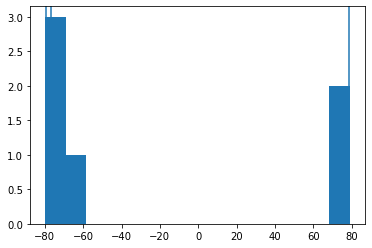

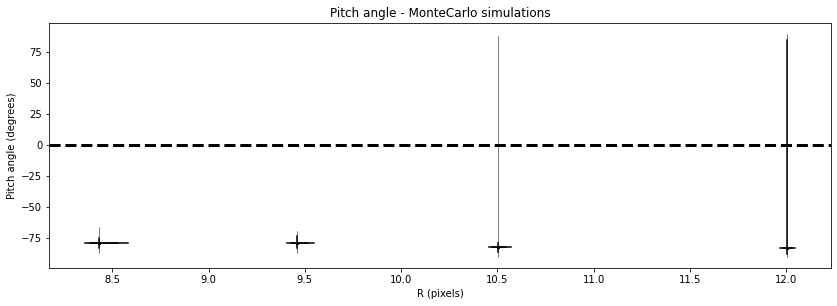

   index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0      7   8.430464   8.354169   8.602193   8.529569   8.382347   8.581523   
1      8   9.457740   9.406115   9.559366   9.515236   9.428131   9.548238   
2      9  10.505183  10.410816  10.582005  10.543522  10.469813  10.572680   
3     10  12.001736  11.957636  12.068744  12.027698  11.980529  12.044587   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   8.357669 -78.856121  -74.425703    -82.934639  -65.993502    -86.503159   
1   9.408129 -78.602276  -73.382645    -82.777122  -68.634171    -86.878501   
2  10.454652 -82.142553  -78.562511    -86.234868   88.342233    -89.659099   
3  11.967883 -83.076781   84.507501    -87.605906   89.321217    -89.689571   

   npix  
0  2.00  
1  3.14  
2  6.05  
3  2.81  
Max radii: 40


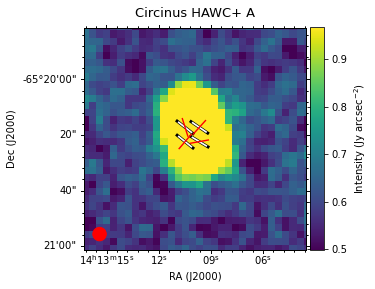

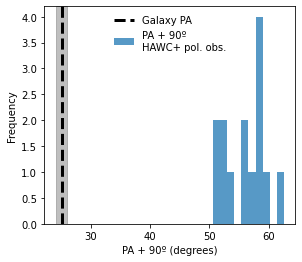

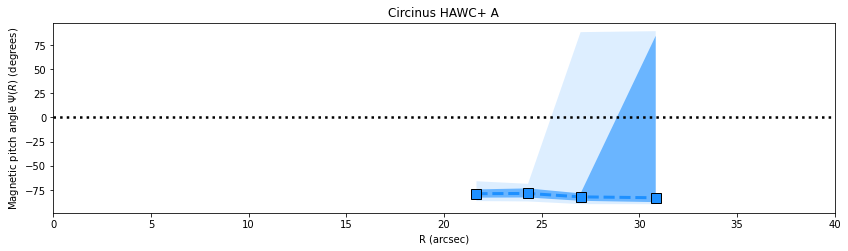

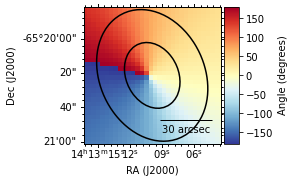

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
50.79904660239479 48.7671286473544


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/49 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 29%|██▊       | 14/49 [00:00<00:00, 137.19it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  1  2  4  5  7  8 10 11 13 14 16 17 19 20 22 23 25 26 27 29 30 32 33
 35 36 38 39 41 42 44 45 47 48 50 51 52 54 55 57 58 60 61 63 64 66 67 69
 70 72]


  0%|          | 0/101 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  8%|▊         | 8/101 [00:00<00:02, 38.78it/s]

            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    0.839116   0.835484   0.843682   0.840662   0.837223   0.841624   
1    1.518377   1.494160   1.546498   1.528456   1.505882   1.538387   
2    3.083307   3.059402   3.187439   3.136104   3.062019   3.166837   
3    4.473306   4.357934   4.559454   4.510685   4.373385   4.538116   
4    6.011377   5.977381   6.067879   6.027691   5.991889   6.053022   
5    7.511009   7.450046   7.577595   7.528665   7.488381   7.537601   
6    9.030527   8.959222   9.087052   9.058429   9.010313   9.076774   
7   10.460301  10.375693  10.534189  10.509011  10.419694  10.531398   
8   12.027938  11.951350  12.127197  12.080728  12.002243  12.119237   
9   13.526527  13.465814  13.619223  13.578990  13.495298  13.612463   
10  15.055745  14.994993  15.109308  15.070648  15.031480  15.088016   
11  16.521872  16.424800  16.582477  16.556162  16.489831  16.572475   
12  18.043744  17.984122  18.126064  18.074350  18.019303  18.10

100%|██████████| 101/101 [00:02<00:00, 39.14it/s]


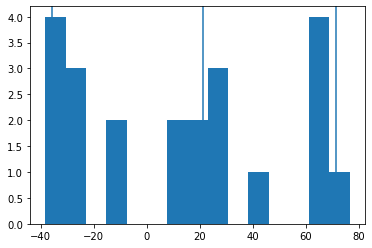

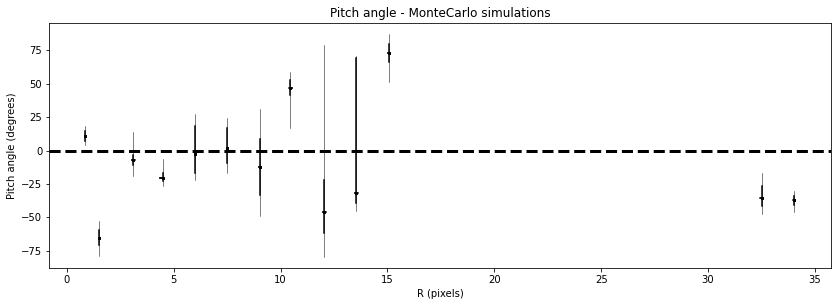

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   0.839116   0.835484   0.843682   0.840662   0.837223   0.841624   
1       1   1.518377   1.494160   1.546498   1.528456   1.505882   1.538387   
2       2   3.083307   3.059402   3.187439   3.136104   3.062019   3.166837   
3       3   4.473306   4.357934   4.559454   4.510685   4.373385   4.538116   
4       4   6.011377   5.977381   6.067879   6.027691   5.991889   6.053022   
5       5   7.511009   7.450046   7.577595   7.528665   7.488381   7.537601   
6       6   9.030527   8.959222   9.087052   9.058429   9.010313   9.076774   
7       7  10.460301  10.375693  10.534189  10.509011  10.419694  10.531398   
8       8  12.027938  11.951350  12.127197  12.080728  12.002243  12.119237   
9       9  13.526527  13.465814  13.619223  13.578990  13.495298  13.612463   
10     10  15.055745  14.994993  15.109308  15.070648  15.031480  15.088016   
11     22  32.508118  32.446515  32.568391  32.53724

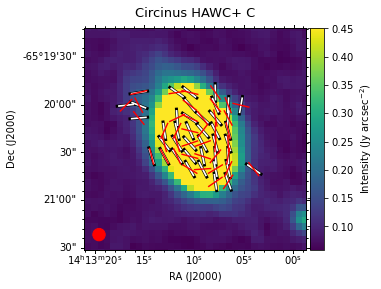

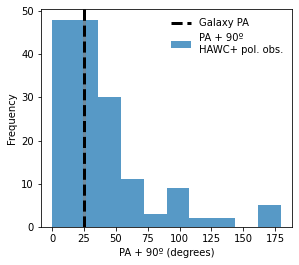

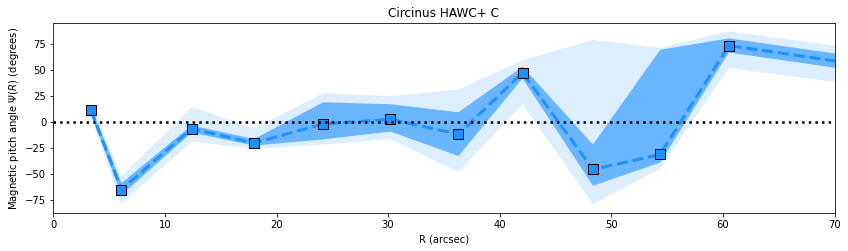

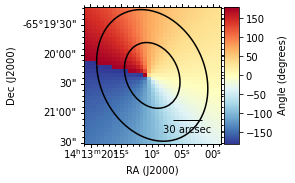

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
37.80126585042254 30.77615037370698


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 35%|███▍      | 17/49 [00:00<00:00, 165.25it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/70 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 4/70 [00:00<00:01, 36.92it/s]

            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    0.839779   0.835492   0.845348   0.841674   0.838246   0.843701   
1    1.516487   1.482940   1.538066   1.523665   1.506619   1.532336   
2    2.376763   2.361947   2.407551   2.387817   2.369330   2.396006   
3    3.460408   3.404488   3.631791   3.476822   3.437150   3.588784   
4    4.421245   4.362105   4.538491   4.499812   4.372818   4.519539   
5    5.458251   5.388645   5.579185   5.521504   5.408015   5.557428   
6    6.537097   6.492306   6.600901   6.574515   6.517400   6.595073   
7    7.510142   7.459696   7.584326   7.527740   7.492800   7.554588   
8    8.528360   8.448824   8.611416   8.548342   8.499898   8.587609   
9    9.510697   9.451213   9.607446   9.533420   9.489114   9.561385   
10  10.441697  10.387531  10.551577  10.498642  10.408158  10.540884   
11  11.517937  11.454074  11.597183  11.558327  11.490828  11.591054   
12  12.489495  12.404788  12.561993  12.528298  12.455694  12.54

100%|██████████| 70/70 [00:01<00:00, 38.57it/s]


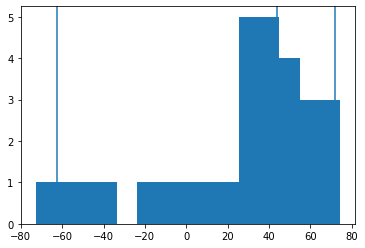

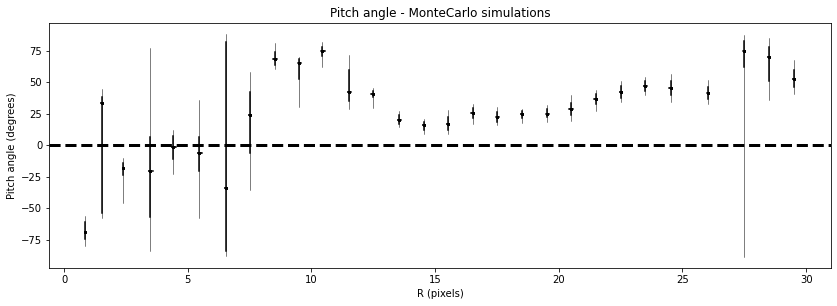

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   0.839779   0.835492   0.845348   0.841674   0.838246   0.843701   
1       1   1.516487   1.482940   1.538066   1.523665   1.506619   1.532336   
2       2   2.376763   2.361947   2.407551   2.387817   2.369330   2.396006   
3       3   3.460408   3.404488   3.631791   3.476822   3.437150   3.588784   
4       4   4.421245   4.362105   4.538491   4.499812   4.372818   4.519539   
5       5   5.458251   5.388645   5.579185   5.521504   5.408015   5.557428   
6       6   6.537097   6.492306   6.600901   6.574515   6.517400   6.595073   
7       7   7.510142   7.459696   7.584326   7.527740   7.492800   7.554588   
8       8   8.528360   8.448824   8.611416   8.548342   8.499898   8.587609   
9       9   9.510697   9.451213   9.607446   9.533420   9.489114   9.561385   
10     10  10.441697  10.387531  10.551577  10.498642  10.408158  10.540884   
11     11  11.517937  11.454074  11.597183  11.55832

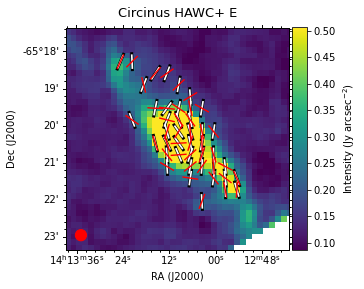

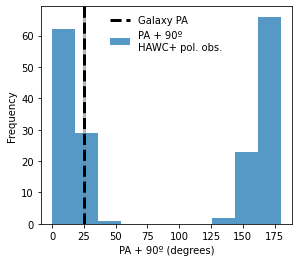

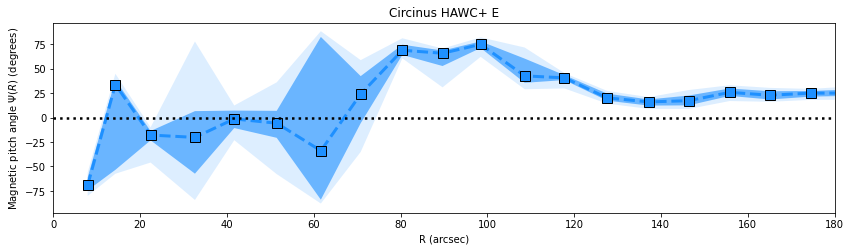

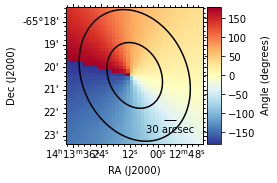

In [13]:
# Circinus A
image_input=legacy_wd+"Circinus_A.fits"
name="Circinus_A_"
source_center = circinus_center
PA = circinus_pa
dPA = 1
incl = circinus_incl
dincl = 1
nbins = 50

plot_title = r'Circinus HAWC+ A'


# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "Circinus_A"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

circinus_a_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=40)

image_input=legacy_wd+"Circinus_C.fits"
name="Circinus_C_"
plot_title = r'Circinus HAWC+ C'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "Circinus_C"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

circinus_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=70)

image_input=legacy_wd+"Circinus_E.fits"
name="Circinus_E_"
plot_title = r'Circinus HAWC+ E'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "Circinus_E"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

circinus_e_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=180)

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
40.33987384847091 42.752077642865544


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/86 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▍         | 4/86 [00:00<00:02, 39.85it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  6 13 20 26 33 40 46 53 60]
           R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0   4.067720   3.855127   4.421742   4.183958   3.952335   4.357378   
1  10.084531   9.820738  10.450544  10.218594   9.962555  10.304571   
2  16.860270  16.675689  17.102298  16.964403  16.784432  17.025047   
3  23.212248  23.078859  23.381920  23.287550  23.138010  23.369554   
4  29.696607  29.569525  29.831339  29.779699  29.623809  29.811386   
5  36.660372  36.523152  36.828237  36.723136  36.614924  36.796788   
6  43.094513  43.017006  43.206269  43.150688  43.048995  43.181683   
7  49.552930  49.393345  49.694727  49.613646  49.490628  49.669049   
8  56.349038  56.181807  56.498991  56.405896  56.286868  56.452540   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   3.872532   1.758711   14.059434    -16.875327   22.407606    -26.895540   
1   9.864483 -23.729691  -16.867610    

100%|██████████| 86/86 [00:02<00:00, 39.74it/s]


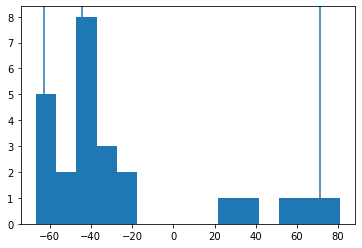

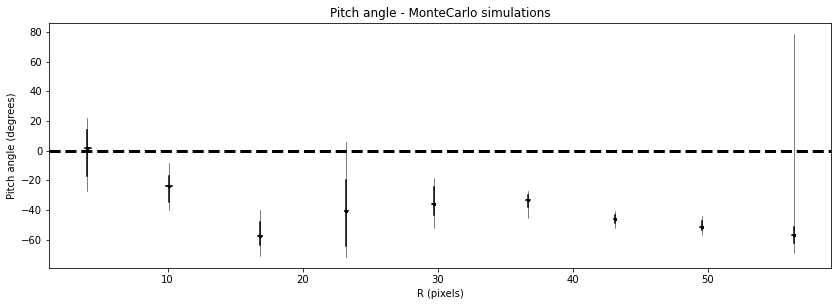

   index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0      0   4.067720   3.855127   4.421742   4.183958   3.952335   4.357378   
1      1  10.084531   9.820738  10.450544  10.218594   9.962555  10.304571   
2      2  16.860270  16.675689  17.102298  16.964403  16.784432  17.025047   
3      3  23.212248  23.078859  23.381920  23.287550  23.138010  23.369554   
4      4  29.696607  29.569525  29.831339  29.779699  29.623809  29.811386   
5      5  36.660372  36.523152  36.828237  36.723136  36.614924  36.796788   
6      6  43.094513  43.017006  43.206269  43.150688  43.048995  43.181683   
7      7  49.552930  49.393345  49.694727  49.613646  49.490628  49.669049   
8      8  56.349038  56.181807  56.498991  56.405896  56.286868  56.452540   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   3.872532   1.758711   14.059434    -16.875327   22.407606    -26.895540   
1   9.864483 -23.729691  -16.867610    -34.714857   -8.097707

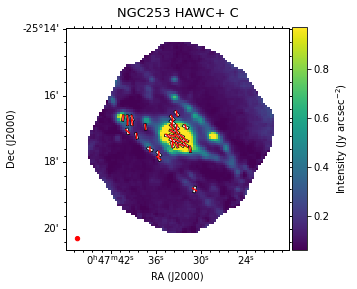

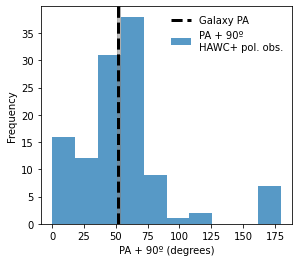

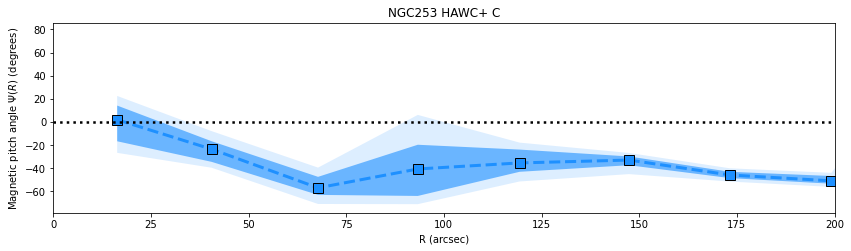

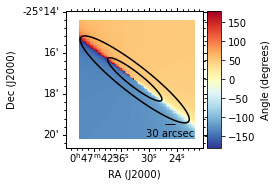

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
31.98222902625441 34.925860237198506


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/9 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/71 [00:00<?, ?it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  5 10 15 21 26 31 37 42 47]
           R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0   3.445641   3.229294   3.862198   3.602925   3.345157   3.816494   
1   7.946179   7.648668   8.183642   8.056992   7.796450   8.107033   
2  12.764928  12.545033  13.027968  12.873933  12.676587  12.946997   
3  18.242150  18.044030  18.538227  18.323632  18.167835  18.495033   
4  23.647365  23.406926  23.861900  23.734791  23.555803  23.799792   
5  28.613829  28.384533  28.873872  28.701219  28.529700  28.782241   
6  34.104956  33.958415  34.219869  34.160444  34.041345  34.203024   
7  39.510516  39.280053  39.722529  39.585483  39.421993  39.655985   
8  44.413703  44.210373  44.632288  44.479640  44.319219  44.573689   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   3.255456 -37.401037  -30.403837    -44.819558  -18.985870    -56.319188   
1   7.757941 -53.039508  -47.666118    

/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 71/71 [00:01<00:00, 40.27it/s]


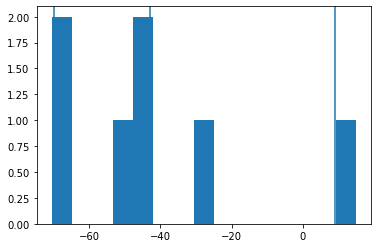

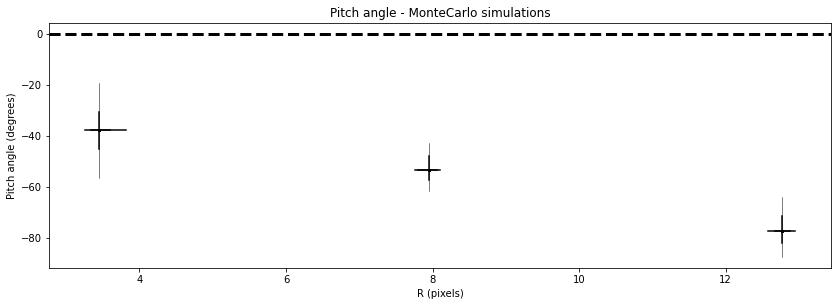

   index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0      0   3.445641   3.229294   3.862198   3.602925   3.345157   3.816494   
1      1   7.946179   7.648668   8.183642   8.056992   7.796450   8.107033   
2      2  12.764928  12.545033  13.027968  12.873933  12.676587  12.946997   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   3.255456 -37.401037  -30.403837    -44.819558  -18.985870    -56.319188   
1   7.757941 -53.039508  -47.666118    -57.035689  -42.725216    -61.424387   
2  12.583105 -77.029625  -71.435534    -82.001123  -63.838680    -87.224615   

    npix  
0   7.33  
1  16.28  
2   4.39  
Max radii: 200


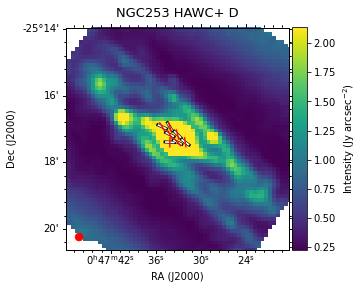

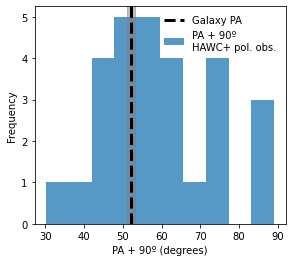

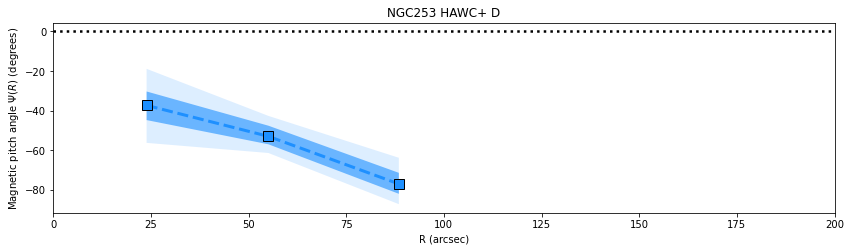

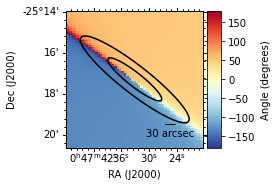

In [14]:
# NGC253


image_input=legacy_wd+"NGC253_C.fits"
name="NGC253_C_"
source_center = ngc253_center
PA = ngc253_pa
dPA = ngc253_dpa
incl = ngc253_incl
dincl = ngc253_dincl
nbins = 10
plot_title = r'NGC253 HAWC+ C'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC253_C"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

ngc253_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=200)

image_input=legacy_wd+"NGC253_D.fits"
name="NGC253_D_"
source_center = ngc253_center
nbins = 10
plot_title = r'NGC253 HAWC+ D'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC253_D"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


ngc253_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=200)

SNR pol limit is 0, switching to inf
33.561833602239304 31.41210297444278


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/19 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 147.77it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  2  5  7 10 12 15 17 20 22 25 27 30 32 35 37 40 43 45 48]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    1.580464   1.509403   1.680046   1.608271   1.548169   1.640681   
1    3.803517   3.717261   3.956641   3.842947   3.755553   3.910197   
2    6.052396   5.988011   6.214604   6.092942   6.023376   6.209175   
3    8.621103   8.582055   8.708824   8.678396   8.598174   8.701755   
4   11.040211  10.993538  11.162979  11.114731  11.008730  11.151017   
5   13.606360  13.522144  13.667956  13.635254  13.573198  13.658235   
6   16.027493  15.977304  16.120891  16.061542  16.007583  16.098665   
7   18.588033  18.526665  18.641247  18.606328  18.567888  18.621758   
8   21.022901  20.976177  21.103647  21.062845  21.001501  21.084792   
9   23.574352  23.517458  23.630225  23.596945  23.549801  23.620294   
10  26.016618  25.970355  26.074927  26.036498  25.995984  26.068132   
11  28.561202 


  0%|          | 0/66 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 12%|█▏        | 8/66 [00:00<00:01, 38.33it/s]

Pitch angle model generated: M51_D_pitch_model.fits
Pitch angle profile generated: M51_D_profile.csv


100%|██████████| 66/66 [00:01<00:00, 40.58it/s]


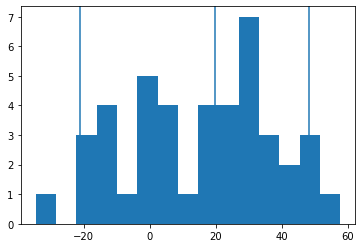

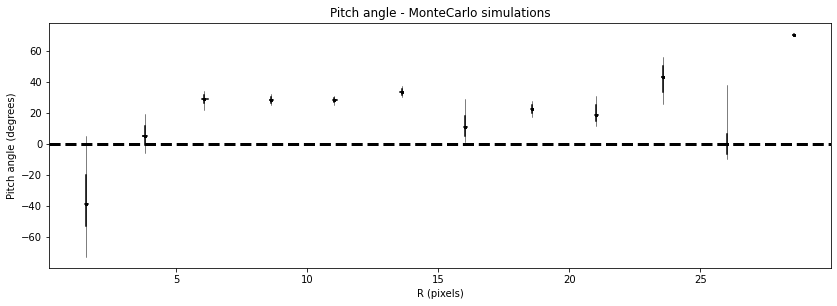

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   1.580464   1.509403   1.680046   1.608271   1.548169   1.640681   
1       1   3.803517   3.717261   3.956641   3.842947   3.755553   3.910197   
2       2   6.052396   5.988011   6.214604   6.092942   6.023376   6.209175   
3       3   8.621103   8.582055   8.708824   8.678396   8.598174   8.701755   
4       4  11.040211  10.993538  11.162979  11.114731  11.008730  11.151017   
5       5  13.606360  13.522144  13.667956  13.635254  13.573198  13.658235   
6       6  16.027493  15.977304  16.120891  16.061542  16.007583  16.098665   
7       7  18.588033  18.526665  18.641247  18.606328  18.567888  18.621758   
8       8  21.022901  20.976177  21.103647  21.062845  21.001501  21.084792   
9       9  23.574352  23.517458  23.630225  23.596945  23.549801  23.620294   
10     10  26.016618  25.970355  26.074927  26.036498  25.995984  26.068132   
11     11  28.561202  28.514203  28.614637  28.58188

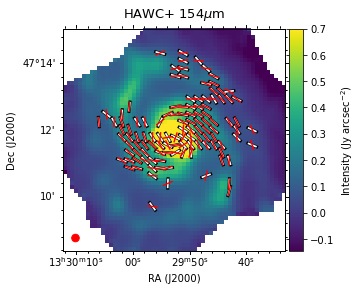

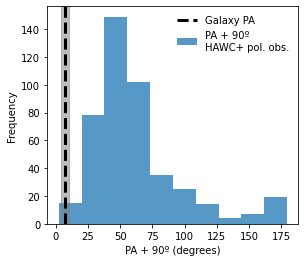

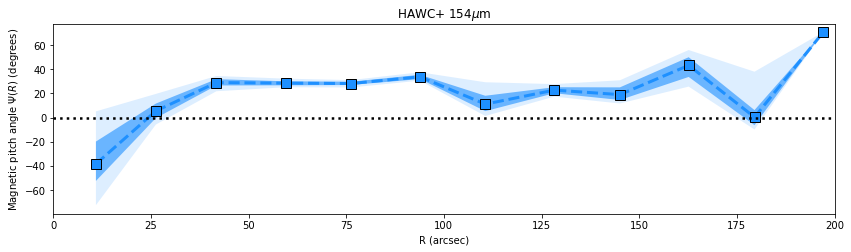

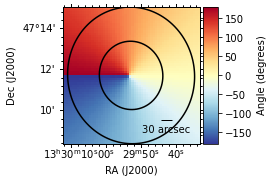

In [15]:
# M51
image_input=legacy_wd+"M51_D.fits"
name="M51_D_"
source_center = m51_center
PA = m51_pa
dPA = m51_dpa
incl = m51_incl
dincl = m51_dincl
nbins = 20
plot_title = r'HAWC+ 154$\mu$m'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "M51"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


m51_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=200)

SNR pol limit is 0, switching to inf
63.09060216030906 57.87826321070995


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/19 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 96.27it/s] 

Simulations done, generating profile from cube
Bin limits: 
[ 0  4  9 13 18 23 27 32 36 41 46 50 55 60 64 69 73 78 83 87]



  0%|          | 0/122 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  8%|▊         | 10/122 [00:00<00:02, 40.74it/s]

            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.486487   2.326623   3.068805   2.909301   2.386339   2.975380   
1    6.948229   6.674867   7.133931   7.059514   6.827345   7.118096   
2   11.147276  11.032128  11.363724  11.233450  11.084650  11.333641   
3   15.680701  15.478066  15.934879  15.806302  15.581320  15.878855   
4   20.647957  20.367006  20.864712  20.737529  20.544895  20.831452   
5   25.084667  24.955535  25.214239  25.145387  25.045856  25.186378   
6   29.609062  29.418711  29.796064  29.724365  29.499590  29.786225   
7   34.062135  33.949401  34.174292  34.095855  34.019173  34.135886   
8   38.577980  38.463878  38.764479  38.666279  38.519482  38.731122   
9   43.565070  43.403621  43.734188  43.631608  43.498319  43.686309   
10  48.047766  47.972676  48.117767  48.081677  48.012466  48.104153   
11  52.563538  52.426127  52.717092  52.630046  52.499662  52.677512   
12  57.549609  57.417271  57.739168  57.610953  57.480769  57.66

100%|██████████| 122/122 [00:02<00:00, 40.80it/s]


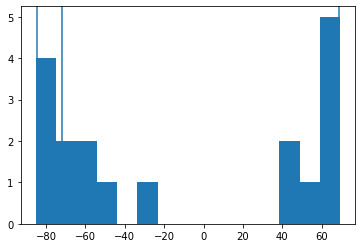

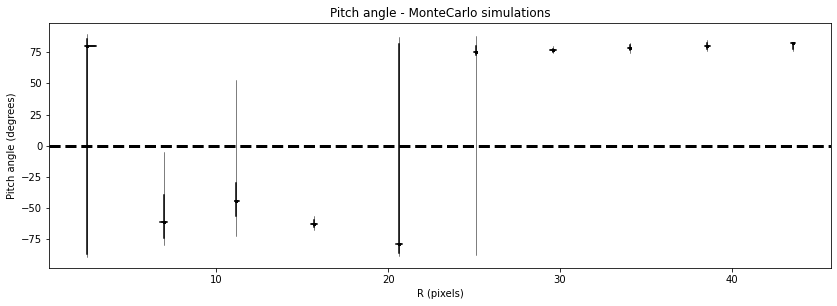

   index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0      0   2.486487   2.326623   3.068805   2.909301   2.386339   2.975380   
1      1   6.948229   6.674867   7.133931   7.059514   6.827345   7.118096   
2      2  11.147276  11.032128  11.363724  11.233450  11.084650  11.333641   
3      3  15.680701  15.478066  15.934879  15.806302  15.581320  15.878855   
4      4  20.647957  20.367006  20.864712  20.737529  20.544895  20.831452   
5      5  25.084667  24.955535  25.214239  25.145387  25.045856  25.186378   
6      6  29.609062  29.418711  29.796064  29.724365  29.499590  29.786225   
7      7  34.062135  33.949401  34.174292  34.095855  34.019173  34.135886   
8      8  38.577980  38.463878  38.764479  38.666279  38.519482  38.731122   
9      9  43.565070  43.403621  43.734188  43.631608  43.498319  43.686309   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   2.337189  80.178664   86.095647    -86.947378   89.478827 

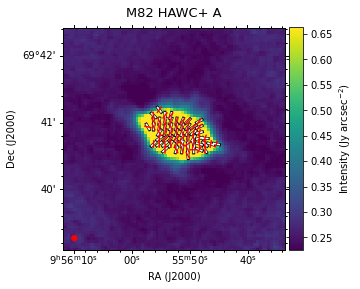

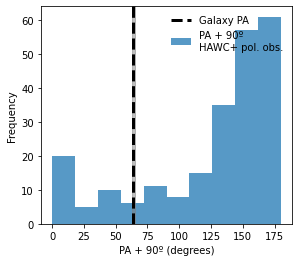

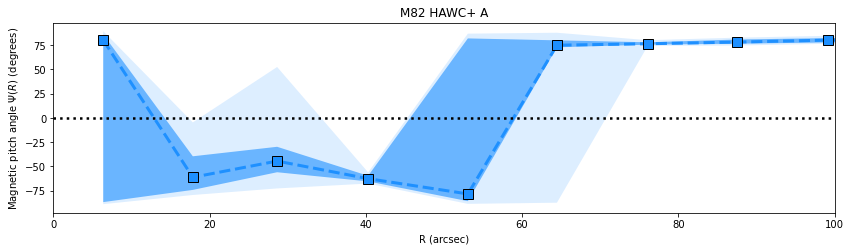

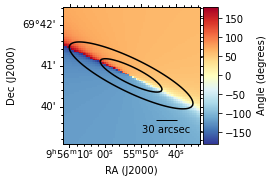

SNR pol limit is 0, switching to inf
53.959663570147846 50.9221732466479


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 63%|██████▎   | 12/19 [00:00<00:00, 117.97it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 113.82it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.422753   2.288742   3.110562   2.486468   2.338668   2.945002   
1    6.249031   6.058186   6.523811   6.381930   6.159575   6.490031   
2   10.187250  10.015953  10.385033  10.274672  10.102391  10.356689   
3   14.171356  13.989708  14.327270  14.237909  14.119467  14.294021   
4   18.088498  18.011278  18.313558  18.158156  18.033835  18.256316   
5   22.090981  21.968632  22.247332  22.145799  22.045462  22.198215   
6   26.084292  25.965212  26.174524  26.125032  26.034989  26.170766   
7   30.059816  29.980970  30.165749  30.106011  30.018524  30.154308   
8   34.066466  33.989700  34.175757  34.099906  34.033738  34.132712   
9   38.060788  37.974583  38.159492  38.095647  38.017938  38.135218   
10  42.054907  41.974315  42.157632  42.087044  42.023979  42.116056   
11  46.049430 


  0%|          | 0/107 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  9%|▉         | 10/107 [00:00<00:02, 40.70it/s]

Pitch angle model generated: M82_C_pitch_model.fits
Pitch angle profile generated: M82_C_profile.csv


100%|██████████| 107/107 [00:02<00:00, 40.73it/s]


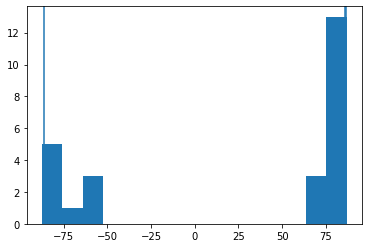

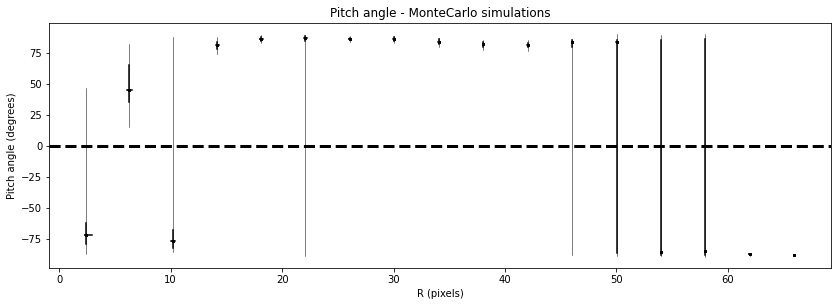

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.422753   2.288742   3.110562   2.486468   2.338668   2.945002   
1       1   6.249031   6.058186   6.523811   6.381930   6.159575   6.490031   
2       2  10.187250  10.015953  10.385033  10.274672  10.102391  10.356689   
3       3  14.171356  13.989708  14.327270  14.237909  14.119467  14.294021   
4       4  18.088498  18.011278  18.313558  18.158156  18.033835  18.256316   
5       5  22.090981  21.968632  22.247332  22.145799  22.045462  22.198215   
6       6  26.084292  25.965212  26.174524  26.125032  26.034989  26.170766   
7       7  30.059816  29.980970  30.165749  30.106011  30.018524  30.154308   
8       8  34.066466  33.989700  34.175757  34.099906  34.033738  34.132712   
9       9  38.060788  37.974583  38.159492  38.095647  38.017938  38.135218   
10     10  42.054907  41.974315  42.157632  42.087044  42.023979  42.116056   
11     11  46.049430  45.995822  46.142531  46.08543

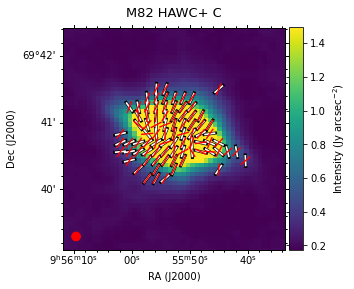

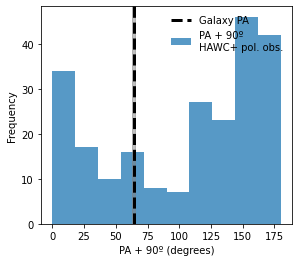

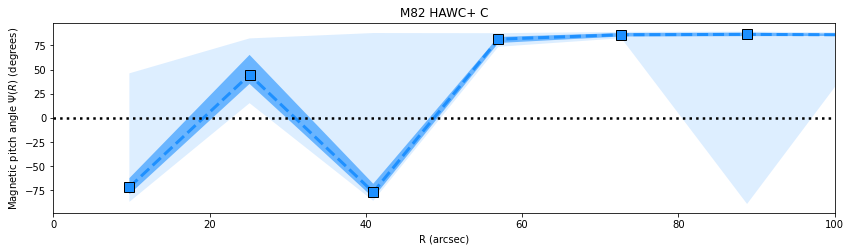

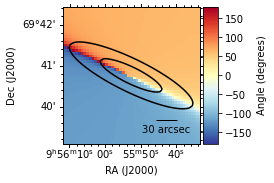

SNR pol limit is 0, switching to inf
41.606471508224296 38.954853744808744


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
100%|██████████| 19/19 [00:00<00:00, 147.76it/s]


Simulations done, generating profile from cube
Bin limits: 
[ 0  3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.117654   1.778649   2.391250   2.218586   1.986354   2.328033   
1    4.791955   4.525501   5.117007   4.850442   4.663668   4.981277   
2    7.676577   7.402572   7.947320   7.764522   7.587885   7.857422   
3   10.609993  10.320305  10.884034  10.718404  10.487573  10.851532   
4   13.556715  13.386474  13.790461  13.631721  13.498484  13.720442   
5   16.588898  16.435574  16.835338  16.665670  16.500954  16.717971   
6   19.564695  19.396326  19.754809  19.667771  19.482301  19.725570   
7   22.520159  22.368437  22.684372  22.583292  22.445548  22.614029   
8   25.556793  25.355719  25.702982  25.621672  25.506694  25.658378   
9   28.545482  28.383425  28.733654  28.607089  28.495346  28.660390   
10  31.531002  31.405561  31.654262  31.587972  31.473503  31.636235   
11  34.542176 

  0%|          | 0/80 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▌         | 4/80 [00:00<00:01, 38.76it/s]

Pitch angle model generated: M82_D_pitch_model.fits
Pitch angle profile generated: M82_D_profile.csv


100%|██████████| 80/80 [00:02<00:00, 39.65it/s]


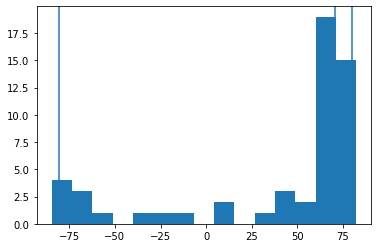

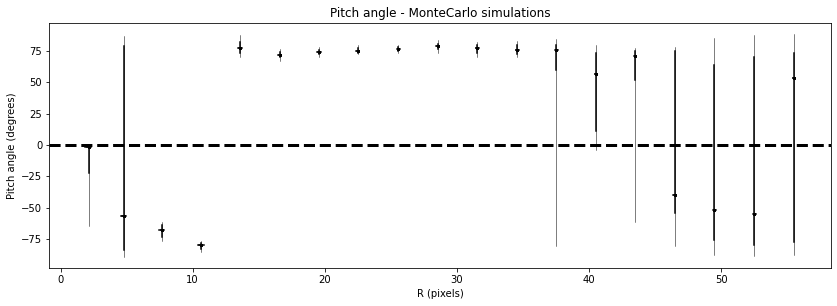

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.117654   1.778649   2.391250   2.218586   1.986354   2.328033   
1       1   4.791955   4.525501   5.117007   4.850442   4.663668   4.981277   
2       2   7.676577   7.402572   7.947320   7.764522   7.587885   7.857422   
3       3  10.609993  10.320305  10.884034  10.718404  10.487573  10.851532   
4       4  13.556715  13.386474  13.790461  13.631721  13.498484  13.720442   
5       5  16.588898  16.435574  16.835338  16.665670  16.500954  16.717971   
6       6  19.564695  19.396326  19.754809  19.667771  19.482301  19.725570   
7       7  22.520159  22.368437  22.684372  22.583292  22.445548  22.614029   
8       8  25.556793  25.355719  25.702982  25.621672  25.506694  25.658378   
9       9  28.545482  28.383425  28.733654  28.607089  28.495346  28.660390   
10     10  31.531002  31.405561  31.654262  31.587972  31.473503  31.636235   
11     11  34.542176  34.431940  34.698244  34.59536

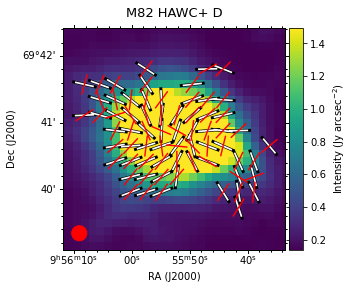

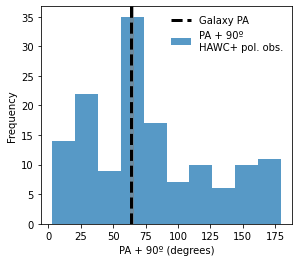

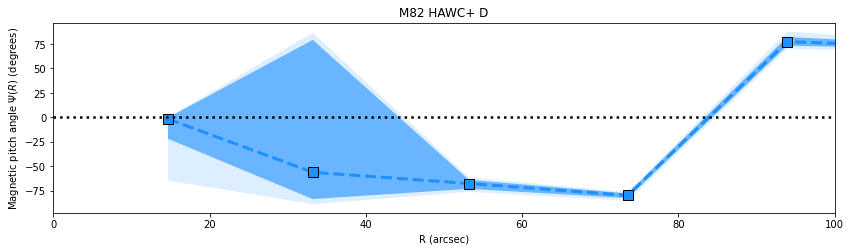

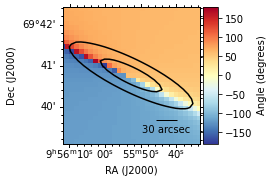

SNR pol limit is 0, switching to inf
52.84335605005243 42.96682252932392


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/19 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 127.91it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  3  7 10 14 18 21 25 29 32 36 39 43 47 50 54 58 61 65 68]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.274882   2.062048   2.339112   2.319763   2.099474   2.333526   
1    5.495860   5.231878   5.731684   5.574371   5.418020   5.634607   
2    8.689627   8.421587   8.889904   8.766082   8.543510   8.855225   
3   12.163491  12.049504  12.449033  12.227136  12.120375  12.328003   
4   16.125356  16.009801  16.309653  16.188077  16.072937  16.265379   
5   19.570351  19.350291  19.720508  19.657898  19.497066  19.683163   
6   23.096134  22.962886  23.222844  23.140891  23.041396  23.205627   
7   27.056025  26.896905  27.254543  27.111210  27.011416  27.198722   
8   30.522971  30.402306  30.645107  30.582527  30.454982  30.637413   
9   34.064530  33.960314  34.178171  34.112008  34.021359  34.158130   
10  37.551333  37.410427  37.704630  37.600874  37.496768  37.665739   
11  41.040185 


  0%|          | 0/94 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 11%|█         | 10/94 [00:00<00:02, 40.62it/s]

Pitch angle model generated: M82_E_pitch_model.fits
Pitch angle profile generated: M82_E_profile.csv


100%|██████████| 94/94 [00:02<00:00, 41.29it/s]


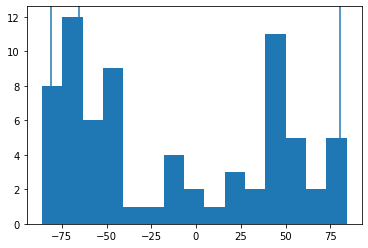

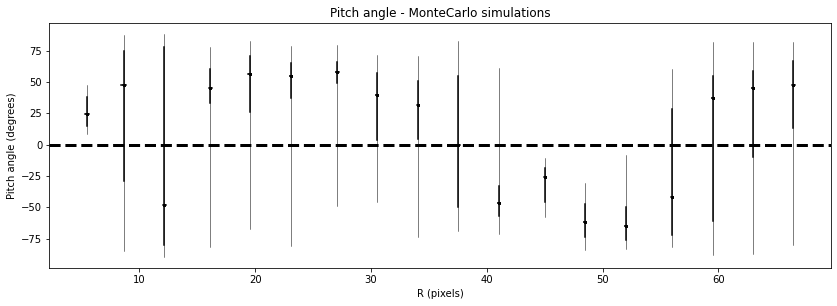

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       1   5.495860   5.231878   5.731684   5.574371   5.418020   5.634607   
1       2   8.689627   8.421587   8.889904   8.766082   8.543510   8.855225   
2       3  12.163491  12.049504  12.449033  12.227136  12.120375  12.328003   
3       4  16.125356  16.009801  16.309653  16.188077  16.072937  16.265379   
4       5  19.570351  19.350291  19.720508  19.657898  19.497066  19.683163   
5       6  23.096134  22.962886  23.222844  23.140891  23.041396  23.205627   
6       7  27.056025  26.896905  27.254543  27.111210  27.011416  27.198722   
7       8  30.522971  30.402306  30.645107  30.582527  30.454982  30.637413   
8       9  34.064530  33.960314  34.178171  34.112008  34.021359  34.158130   
9      10  37.551333  37.410427  37.704630  37.600874  37.496768  37.665739   
10     11  41.040185  40.927897  41.170136  41.087256  41.010696  41.140286   
11     12  45.040158  44.931053  45.116475  45.07229

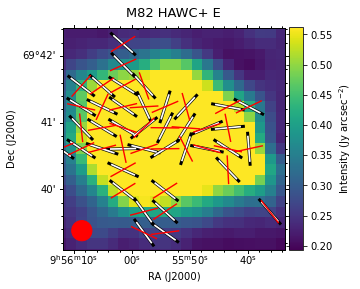

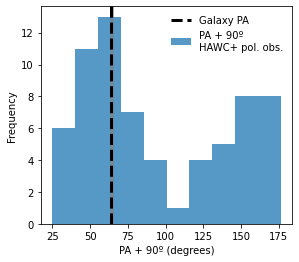

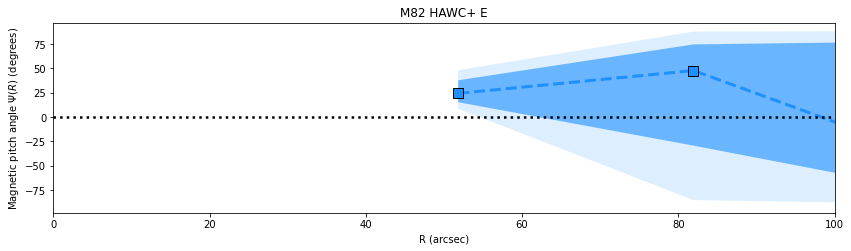

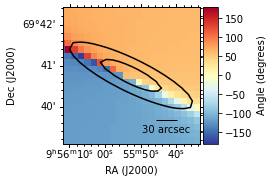

In [16]:
# M82
image_input=legacy_wd+"M82_A.fits"
name="M82_A_"
source_center = m82_center
PA = m82_pa
dPA = 1
incl = m82_incl
dincl = 1
nbins = 20

plot_title = r'M82 HAWC+ A'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "M82_A"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


m82_a_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

image_input=legacy_wd+"M82_C.fits"
name="M82_C_"
plot_title = r'M82 HAWC+ C'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "M82_C"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


m82_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

image_input=legacy_wd+"M82_D.fits"
name="M82_D_"
plot_title = r'M82 HAWC+ D'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "M82_D"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

m82_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

image_input=legacy_wd+"M82_E.fits"
name="M82_E_"
plot_title = r'M82 HAWC+ E'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "M82_E"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


m82_e_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)



/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
37.55832982758276 39.88663359525209


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 68%|██████▊   | 13/19 [00:00<00:00, 127.98it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 129.20it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  2  5  8 11 14 17 20 23 26 29 32 35 38 41 44 47 50 53 56]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    1.424643   1.306167   1.537818   1.528577   1.415601   1.533674   
1    3.783430   3.767697   3.816347   3.799478   3.772822   3.814170   
2    6.693208   6.650056   6.719689   6.706666   6.674683   6.716359   
3    9.619824   9.589532   9.651460   9.629361   9.609919   9.640249   
4   12.588107  12.561210  12.637093  12.608328  12.574412  12.632865   
5   15.570746  15.524918  15.609900  15.591137  15.552594  15.601572   
6   18.571014  18.513284  18.602793  18.586332  18.538649  18.601055   
7   21.567223  21.523084  21.601491  21.580830  21.550476  21.597940   
8   24.548186  24.530702  24.586977  24.561711  24.540294  24.581834   
9   27.532034  27.468502  27.606255  27.557578  27.498838  27.570918   
10  30.526873  30.448917  30.606617  30.551998  30.495366  30.584595   
11  33.512645 


  0%|          | 0/81 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▍         | 4/81 [00:00<00:02, 37.13it/s]

Pitch angle model generated: M83_D_pitch_model.fits
Pitch angle profile generated: M83_D_profile.csv


100%|██████████| 81/81 [00:02<00:00, 38.51it/s]


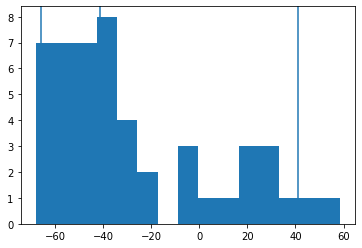

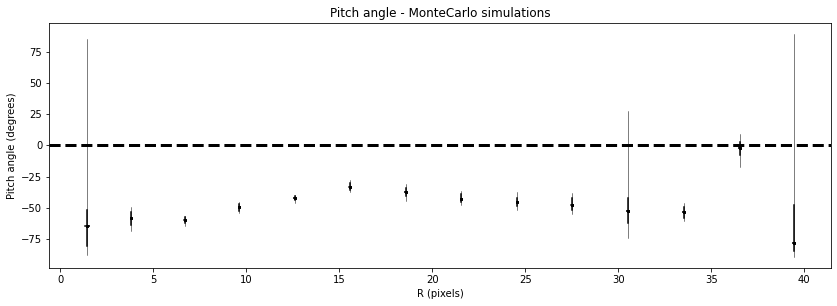

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   1.424643   1.306167   1.537818   1.528577   1.415601   1.533674   
1       1   3.783430   3.767697   3.816347   3.799478   3.772822   3.814170   
2       2   6.693208   6.650056   6.719689   6.706666   6.674683   6.716359   
3       3   9.619824   9.589532   9.651460   9.629361   9.609919   9.640249   
4       4  12.588107  12.561210  12.637093  12.608328  12.574412  12.632865   
5       5  15.570746  15.524918  15.609900  15.591137  15.552594  15.601572   
6       6  18.571014  18.513284  18.602793  18.586332  18.538649  18.601055   
7       7  21.567223  21.523084  21.601491  21.580830  21.550476  21.597940   
8       8  24.548186  24.530702  24.586977  24.561711  24.540294  24.581834   
9       9  27.532034  27.468502  27.606255  27.557578  27.498838  27.570918   
10     10  30.526873  30.448917  30.606617  30.551998  30.495366  30.584595   
11     11  33.512645  33.471013  33.563533  33.53174

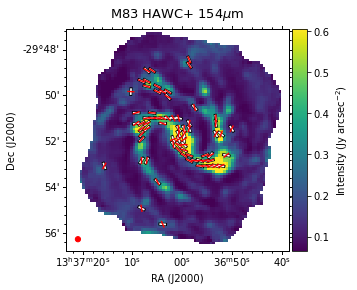

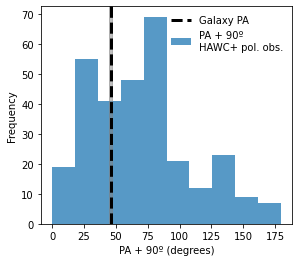

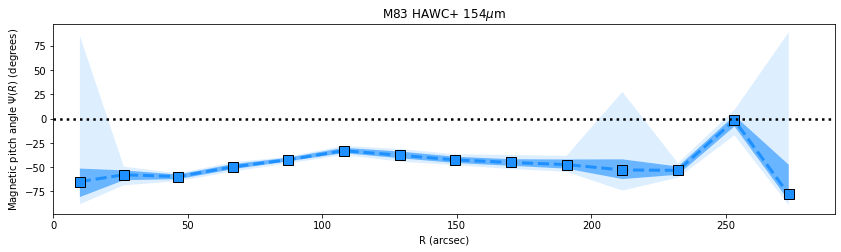

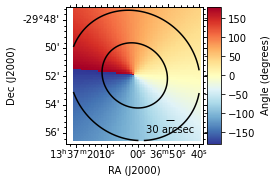

In [17]:
# M83
image_input=legacy_wd+"M83_D.fits"
name="M83_D_"
source_center = m83_center
PA = m83_pa
dPA = 1
incl = m83_incl
dincl = 1
nbins = 20
plot_title = r'M83 HAWC+ 154$\mu$m'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "M83"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


m83_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue")


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
52.766091949588706 53.71567690051867


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/19 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 100.61it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  3  7 11 15 19 23 27 31 35 39 43 47 51 55 59 63 67 71 75]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.172285   2.143304   2.192616   2.182262   2.164330   2.189611   
1    5.414978   5.338968   5.486733   5.440172   5.381183   5.474285   
2    9.205787   9.143414   9.306237   9.250791   9.163661   9.289874   
3   13.184072  13.098237  13.228353  13.207120  13.146524  13.220383   
4   17.097043  17.059384  17.201204  17.143929  17.076319  17.178547   
5   21.068330  21.031375  21.130059  21.091099  21.050778  21.119273   
6   25.085116  25.029736  25.155153  25.119133  25.054514  25.136567   
7   29.082615  29.026139  29.131200  29.099802  29.055595  29.124435   
8   33.056881  33.020250  33.122102  33.079770  33.039235  33.104898   
9   37.059433  36.988155  37.129484  37.089865  37.033950  37.117870   
10  41.049010  41.008107  41.093638  41.062652  41.028908  41.083299   
11  45.039895 


  0%|          | 0/107 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  8%|▊         | 9/107 [00:00<00:02, 40.45it/s]

Pitch angle model generated: NGC1068_A_pitch_model.fits
Pitch angle profile generated: NGC1068_A_profile.csv


100%|██████████| 107/107 [00:03<00:00, 33.58it/s]


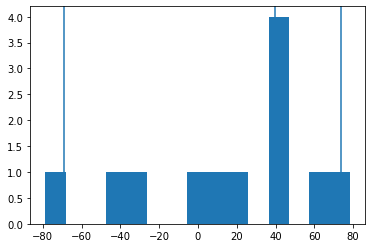

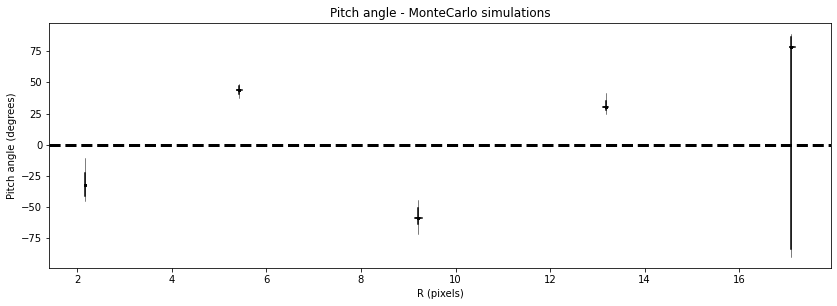

   index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0      0   2.172285   2.143304   2.192616   2.182262   2.164330   2.189611   
1      1   5.414978   5.338968   5.486733   5.440172   5.381183   5.474285   
2      2   9.205787   9.143414   9.306237   9.250791   9.163661   9.289874   
3      3  13.184072  13.098237  13.228353  13.207120  13.146524  13.220383   
4      4  17.097043  17.059384  17.201204  17.143929  17.076319  17.178547   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   2.160297 -32.136695  -22.279175    -41.002632  -10.562394    -45.064152   
1   5.369148  43.700456   46.798294     40.451966   48.829600     37.292064   
2   9.149237 -58.381296  -50.952228    -63.851146  -44.361524    -71.763860   
3  13.116632  30.594091   35.341274     27.631587   41.713188     24.344346   
4  17.063313  78.305794   86.090451    -83.937497   88.651570    -89.803907   

    npix  
0   2.95  
1  14.05  
2   2.00  
3   2.00  
4

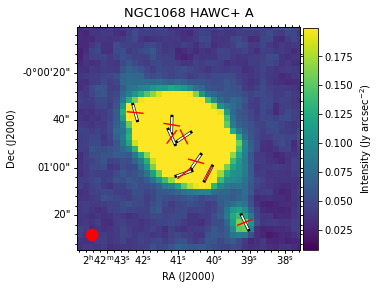

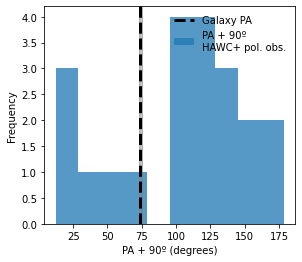

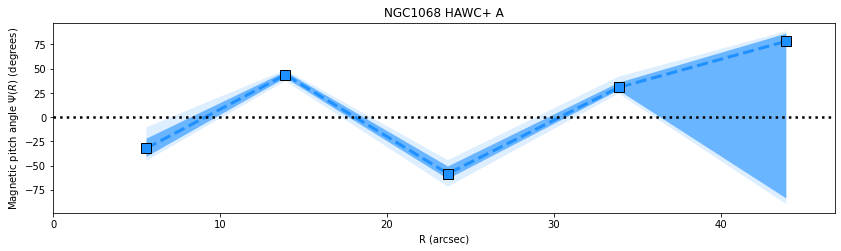

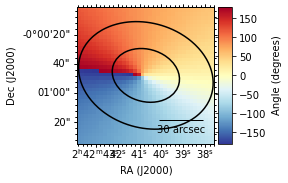

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
44.77524393028374 41.47049169429186


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/19 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 125.23it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  3  6  9 12 16 19 22 25 29 32 35 38 42 45 48 51 55 58 61]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.242930   2.141526   2.299293   2.269949   2.160326   2.289499   
1    4.743528   4.711160   4.815377   4.763322   4.729081   4.808492   
2    7.666680   7.628336   7.718195   7.690126   7.647825   7.713579   
3   10.663837  10.592145  10.726015  10.693370  10.633630  10.707975   
4   14.139792  14.069659  14.198264  14.169641  14.119188  14.191914   
5   17.603053  17.544291  17.663787  17.642140  17.580644  17.659770   
6   20.571848  20.508153  20.646993  20.612301  20.531981  20.638786   
7   23.553976  23.503878  23.605964  23.580624  23.526150  23.603506   
8   27.066056  27.026532  27.120362  27.086915  27.048683  27.106900   
9   30.531949  30.448334  30.584630  30.550964  30.500085  30.571547   
10  33.494500  33.461535  33.546949  33.517842  33.478343  33.538681   
11  36.501989 


  0%|          | 0/86 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 16%|█▋        | 14/86 [00:00<00:01, 40.63it/s]

Pitch angle model generated: NGC1068_C_pitch_model.fits
Pitch angle profile generated: NGC1068_C_profile.csv


100%|██████████| 86/86 [00:02<00:00, 41.42it/s]


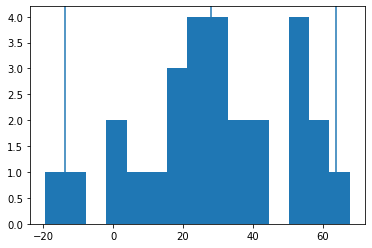

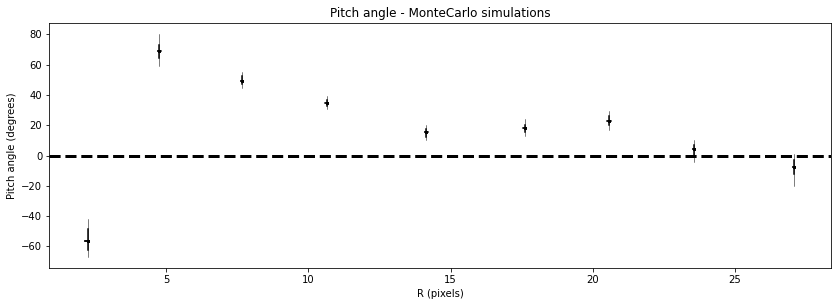

   index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0      0   2.242930   2.141526   2.299293   2.269949   2.160326   2.289499   
1      1   4.743528   4.711160   4.815377   4.763322   4.729081   4.808492   
2      2   7.666680   7.628336   7.718195   7.690126   7.647825   7.713579   
3      3  10.663837  10.592145  10.726015  10.693370  10.633630  10.707975   
4      4  14.139792  14.069659  14.198264  14.169641  14.119188  14.191914   
5      5  17.603053  17.544291  17.663787  17.642140  17.580644  17.659770   
6      6  20.571848  20.508153  20.646993  20.612301  20.531981  20.638786   
7      7  23.553976  23.503878  23.605964  23.580624  23.526150  23.603506   
8      8  27.066056  27.026532  27.120362  27.086915  27.048683  27.106900   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   2.146233 -56.466712  -48.663630    -62.384361  -41.616066    -66.769928   
1   4.717642  68.901587   73.103019     64.491559   80.007271

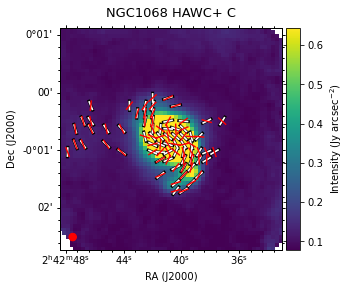

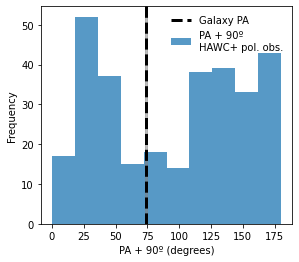

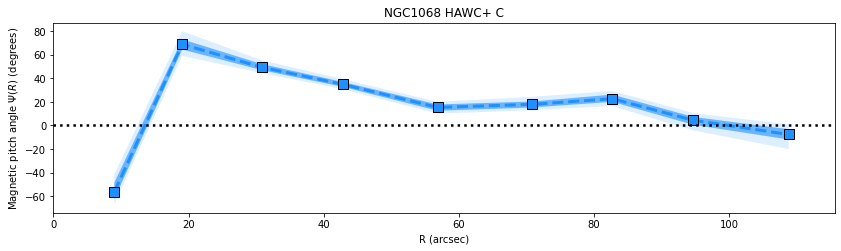

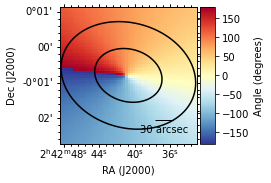

In [18]:
# NGC1068

image_input=legacy_wd+"NGC1068_A.fits"
name="NGC1068_A_"
source_center = ngc1068_center
PA = ngc1068_pa
dPA = 1
incl = ngc1068_incl
dincl = 1
nbins = 20
plot_title = r'NGC1068 HAWC+ A'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC1068_A"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


ngc1068_a_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue")



image_input=legacy_wd+"NGC1068_C.fits"
name="NGC1068_C_"
plot_title = r'NGC1068 HAWC+ C'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC1068_C"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

ngc1068_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue")


SNR pol limit is 0, switching to inf
43.56801865601828 47.277576867142585


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 63%|██████▎   | 12/19 [00:00<00:00, 115.86it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 110.00it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  3  6 10 13 16 20 23 27 30 33 37 40 44 47 50 54 57 60 64]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    1.986042   1.936471   2.139743   2.063271   1.944340   2.138203   
1    4.724579   4.625086   4.827215   4.811755   4.636246   4.822013   
2    8.227589   8.197164   8.295430   8.249030   8.207148   8.280957   
3   11.581441  11.529225  11.625409  11.599715  11.562639  11.616866   
4   14.532690  14.508738  14.588889  14.543995  14.521169  14.567126   
5   18.085786  18.042579  18.168354  18.124889  18.058459  18.162723   
6   21.524419  21.495141  21.559616  21.537225  21.508137  21.546691   
7   25.076313  25.041947  25.107529  25.086869  25.063225  25.094857   
8   28.511522  28.458468  28.576344  28.523772  28.492311  28.551855   
9   31.540920  31.490700  31.577319  31.557436  31.525266  31.576082   
10  35.052077  35.011912  35.120786  35.083147  35.034917  35.117685   
11  38.513162 


  0%|          | 0/94 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 15%|█▍        | 14/94 [00:00<00:02, 39.92it/s]

Pitch angle model generated: NGC1097_C_pitch_model.fits
Pitch angle profile generated: NGC1097_C_profile.csv


100%|██████████| 94/94 [00:02<00:00, 40.48it/s]


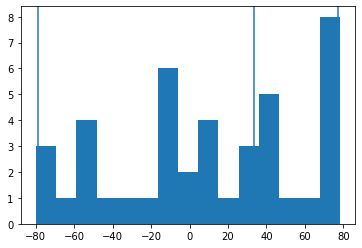

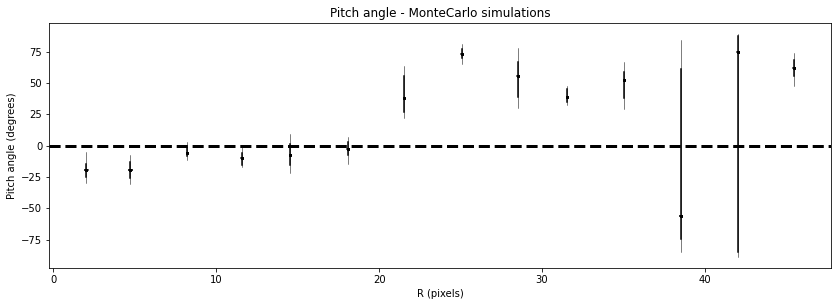

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   1.986042   1.936471   2.139743   2.063271   1.944340   2.138203   
1       1   4.724579   4.625086   4.827215   4.811755   4.636246   4.822013   
2       2   8.227589   8.197164   8.295430   8.249030   8.207148   8.280957   
3       3  11.581441  11.529225  11.625409  11.599715  11.562639  11.616866   
4       4  14.532690  14.508738  14.588889  14.543995  14.521169  14.567126   
5       5  18.085786  18.042579  18.168354  18.124889  18.058459  18.162723   
6       6  21.524419  21.495141  21.559616  21.537225  21.508137  21.546691   
7       7  25.076313  25.041947  25.107529  25.086869  25.063225  25.094857   
8       8  28.511522  28.458468  28.576344  28.523772  28.492311  28.551855   
9       9  31.540920  31.490700  31.577319  31.557436  31.525266  31.576082   
10     10  35.052077  35.011912  35.120786  35.083147  35.034917  35.117685   
11     11  38.513162  38.462707  38.584925  38.53925

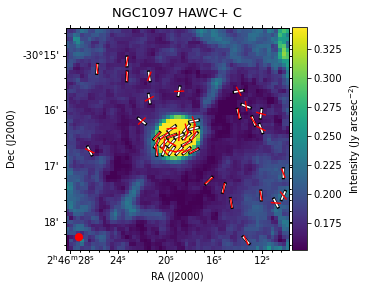

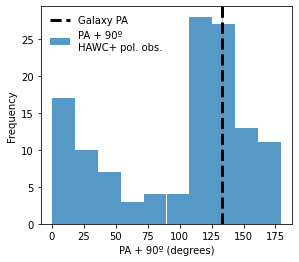

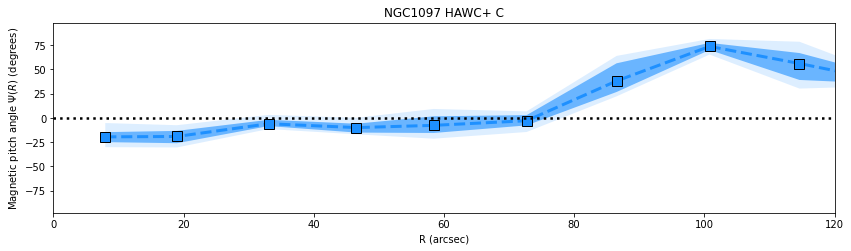

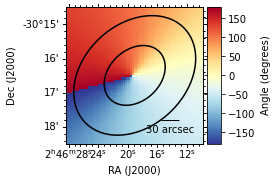

SNR pol limit is 0, switching to inf
36.42416863179827 39.11135621901024


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/19 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/78 [00:00<?, ?it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  2  5  8 11 14 16 19 22 25 28 30 33 36 39 42 44 47 50 53]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    1.455106   1.416919   1.491141   1.469613   1.446798   1.477219   
1    3.871035   3.862493   3.871407   3.871150   3.870821   3.871338   
2    6.696049   6.579733   6.698830   6.696081   6.687240   6.697193   
3    9.675184   9.523851   9.687961   9.682784   9.663779   9.685427   
4   12.554060  12.504589  12.575560  12.562628  12.545917  12.570422   
5   15.074932  15.022927  15.134063  15.104294  15.041755  15.128690   
6   17.606490  17.549884  17.653923  17.636611  17.568646  17.646181   
7   20.505359  20.471292  20.560485  20.523675  20.488090  20.538459   
8   23.560732  23.506527  23.625124  23.595207  23.540983  23.620435   
9   26.557255  26.511700  26.619304  26.584987  26.537909  26.604506   
10  29.021253  28.977455  29.051076  29.034365  29.007429  29.049444   
11  31.550408 

/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 78/78 [00:01<00:00, 41.86it/s]


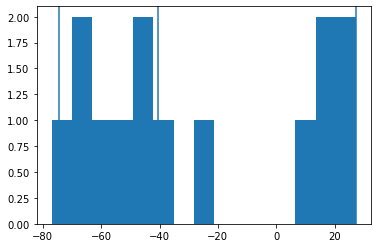

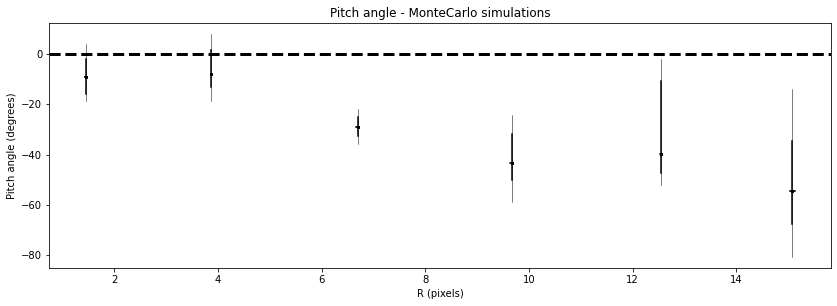

   index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0      0   1.455106   1.416919   1.491141   1.469613   1.446798   1.477219   
1      1   3.871035   3.862493   3.871407   3.871150   3.870821   3.871338   
2      2   6.696049   6.579733   6.698830   6.696081   6.687240   6.697193   
3      3   9.675184   9.523851   9.687961   9.682784   9.663779   9.685427   
4      4  12.554060  12.504589  12.575560  12.562628  12.545917  12.570422   
5      5  15.074932  15.022927  15.134063  15.104294  15.041755  15.128690   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   1.436286  -8.984120   -1.858569    -15.758177    4.181357    -18.724228   
1   3.863064  -7.894791    1.663798    -12.914288    7.870707    -18.847791   
2   6.673367 -28.789303  -25.201471    -32.597288  -21.892134    -35.682751   
3   9.639787 -43.491602  -31.574155    -50.128174  -24.413087    -58.665428   
4  12.527533 -39.855981  -10.705150    -47.151450   -1.756

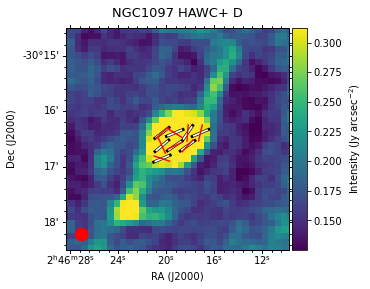

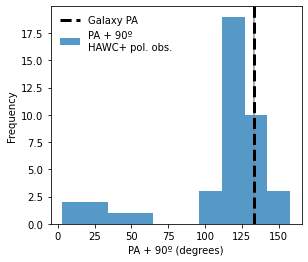

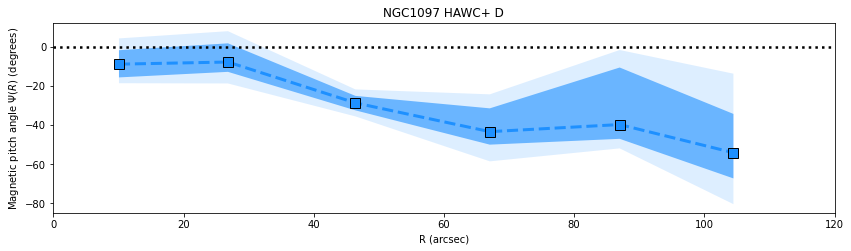

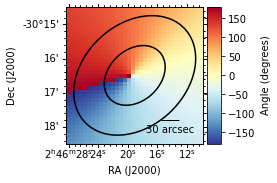

In [19]:
# NGC1097
image_input=legacy_wd+"NGC1097_C.fits"
name="NGC1097_C_"
source_center = ngc1097_center
PA = ngc1097_pa
dPA = ngc1097_dpa
incl = ngc1097_incl
dincl = ngc1097_dincl
nbins = 20
plot_title = r'NGC1097 HAWC+ C'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC1097_C"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

ngc1097_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=120)

image_input=legacy_wd+"NGC1097_D.fits"
name="NGC1097_D_"
plot_title = r'NGC1097 HAWC+ D'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC1097_D"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


ngc1097_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=120)


SNR pol limit is 0, switching to inf
49.742239253216084 49.699718786720744


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/14 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 14/14 [00:00<00:00, 109.36it/s]


Simulations done, generating profile from cube
Bin limits: 
[ 0  5 10 15 20 25 31 36 41 46 51 56 62 67 72]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    3.447806   3.317719   3.758379   3.570726   3.363495   3.628699   
1    7.873127   7.716551   8.097049   7.984690   7.799142   8.070323   
2   12.732539  12.517920  12.889680  12.811407  12.662942  12.881051   
3   17.663757  17.515658  17.807856  17.727259  17.598736  17.787566   
4   22.632312  22.500270  22.764536  22.691551  22.579875  22.749254   
5   28.159082  28.088010  28.293914  28.191710  28.128853  28.240655   
6   33.602166  33.448709  33.713985  33.648802  33.544485  33.695986   
7   38.590765  38.491748  38.690258  38.643344  38.549066  38.672566   
8   43.575566  43.476460  43.686671  43.624384  43.539404  43.662594   
9   48.555745  48.491494  48.659134  48.603358  48.526601  48.644340   
10  53.562461  53.498184  53.661986  53.606467  53.524816  53.643595   
11  59.057689  58.947068  59.

  0%|          | 0/105 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 14%|█▍        | 15/105 [00:00<00:02, 42.31it/s]

Pitch angle model generated: NGC2146_A_pitch_model.fits
Pitch angle profile generated: NGC2146_A_profile.csv


100%|██████████| 105/105 [00:02<00:00, 41.96it/s]


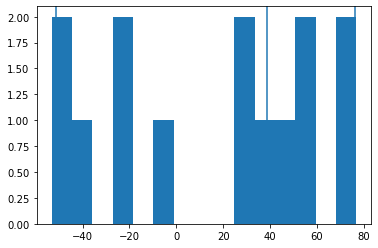

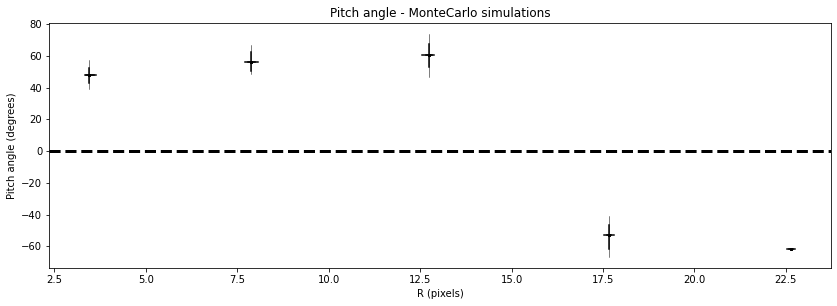

   index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0      0   3.447806   3.317719   3.758379   3.570726   3.363495   3.628699   
1      1   7.873127   7.716551   8.097049   7.984690   7.799142   8.070323   
2      2  12.732539  12.517920  12.889680  12.811407  12.662942  12.881051   
3      3  17.663757  17.515658  17.807856  17.727259  17.598736  17.787566   
4      4  22.632312  22.500270  22.764536  22.691551  22.579875  22.749254   

    R_s2down      pitch  pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down  \
0   3.329921  47.894388   52.255537     42.712655   57.215598     39.102374   
1   7.720469  56.344981   62.713379     50.647854   66.718603     48.413347   
2  12.550391  60.325663   67.330863     52.820714   73.575520     46.542160   
3  17.528117 -53.073278  -46.410321    -61.521618  -40.986517    -66.520712   
4  22.520757 -61.465170  -61.465170    -61.465170  -61.465170    -61.465170   

    npix  
0  30.39  
1  32.27  
2   6.62  
3   0.71  
4

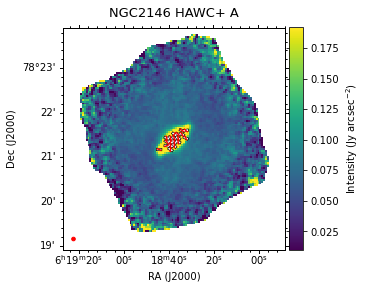

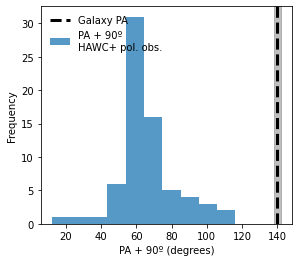

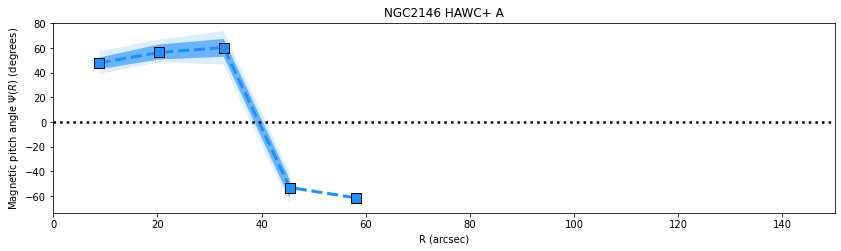

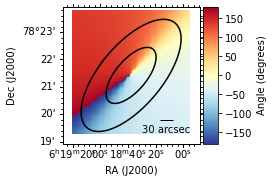

SNR pol limit is 0, switching to inf
36.980007012319206 38.82246934901549


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
100%|██████████| 14/14 [00:00<00:00, 134.17it/s]


Simulations done, generating profile from cube
Bin limits: 
[ 0  3  7 11 15 19 23 27 31 35 39 43 46 50 54]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.002307   1.869717   2.414261   2.171015   1.935171   2.396881   
1    5.307532   5.168946   5.490594   5.389622   5.261726   5.463392   
2    9.209436   8.960476   9.351139   9.271741   9.120831   9.308768   
3   13.160864  12.990915  13.329663  13.248413  13.083416  13.310212   
4   17.130457  16.963762  17.256983  17.183967  17.069453  17.216071   
5   21.109254  20.960281  21.199812  21.157045  21.045925  21.190089   
6   25.074473  24.966847  25.187406  25.123921  25.020125  25.168255   
7   29.072634  28.978010  29.176323  29.112778  29.010810  29.159645   
8   33.065801  32.942077  33.172743  33.111641  33.027441  33.156089   
9   37.047706  36.952837  37.148619  37.106055  37.011931  37.130936   
10  41.044765  40.960792  41.149354  41.096186  41.002885  41.132789   
11  44.518413  44.441745  44.

  0%|          | 0/77 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▋         | 5/77 [00:00<00:01, 42.21it/s]

Pitch angle model generated: NGC2146_C_pitch_model.fits
Pitch angle profile generated: NGC2146_C_profile.csv


100%|██████████| 77/77 [00:01<00:00, 41.59it/s]


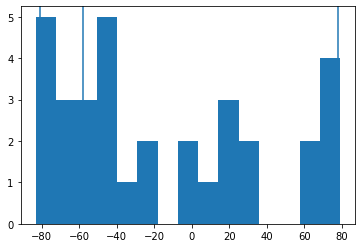

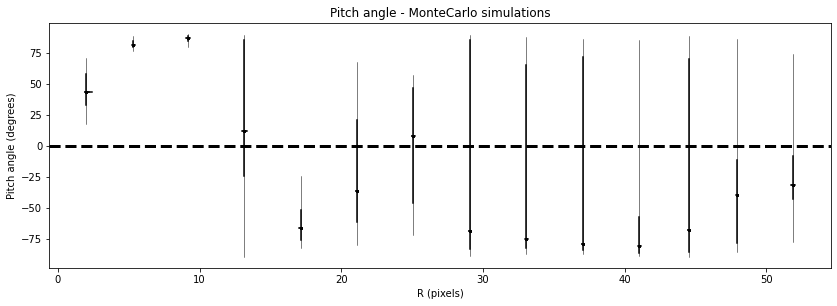

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.002307   1.869717   2.414261   2.171015   1.935171   2.396881   
1       1   5.307532   5.168946   5.490594   5.389622   5.261726   5.463392   
2       2   9.209436   8.960476   9.351139   9.271741   9.120831   9.308768   
3       3  13.160864  12.990915  13.329663  13.248413  13.083416  13.310212   
4       4  17.130457  16.963762  17.256983  17.183967  17.069453  17.216071   
5       5  21.109254  20.960281  21.199812  21.157045  21.045925  21.190089   
6       6  25.074473  24.966847  25.187406  25.123921  25.020125  25.168255   
7       7  29.072634  28.978010  29.176323  29.112778  29.010810  29.159645   
8       8  33.065801  32.942077  33.172743  33.111641  33.027441  33.156089   
9       9  37.047706  36.952837  37.148619  37.106055  37.011931  37.130936   
10     10  41.044765  40.960792  41.149354  41.096186  41.002885  41.132789   
11     11  44.518413  44.441745  44.600120  44.53838

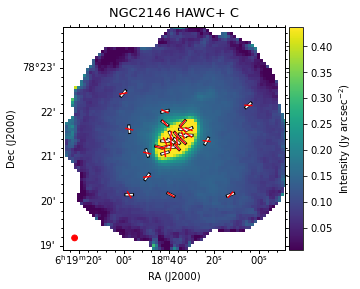

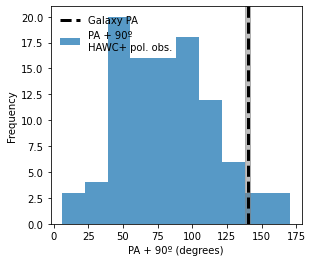

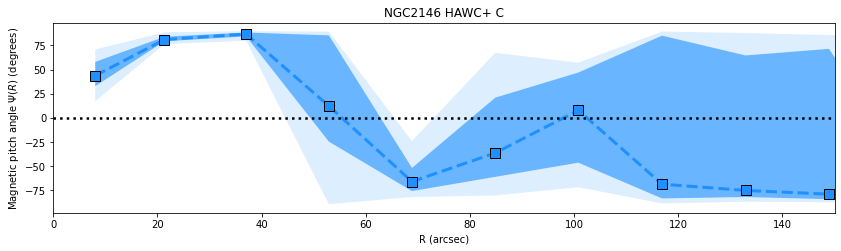

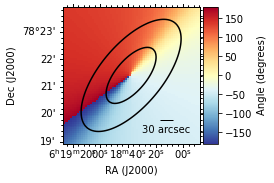

SNR pol limit is 0, switching to inf
40.77844562619382 41.97710343189643


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
100%|██████████| 14/14 [00:00<00:00, 118.67it/s]


Simulations done, generating profile from cube
Bin limits: 
[ 0  4  8 13 17 21 26 30 34 39 43 47 52 56 60]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.823411   2.718532   3.054681   2.893501   2.746180   3.038111   
1    6.249342   6.112607   6.488042   6.302993   6.215779   6.426008   
2   10.815076  10.586667  10.930994  10.853593  10.741591  10.891761   
3   15.138737  14.956044  15.303118  15.203498  15.058608  15.272933   
4   19.105235  18.966521  19.249292  19.163867  19.059156  19.209929   
5   23.630451  23.558646  23.717924  23.669996  23.592984  23.710418   
6   28.073873  27.939871  28.159688  28.119059  28.018457  28.157900   
7   32.069109  31.962322  32.179488  32.102347  32.015716  32.152500   
8   36.583794  36.523869  36.655593  36.618418  36.563076  36.639437   
9   41.046521  40.964429  41.136013  41.090191  41.010645  41.122141   
10  45.045301  44.949958  45.123661  45.091435  45.001954  45.110316   
11  49.507157  49.412470  49.

  0%|          | 0/87 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  9%|▉         | 8/87 [00:00<00:02, 38.82it/s]

Pitch angle model generated: NGC2146_D_pitch_model.fits
Pitch angle profile generated: NGC2146_D_profile.csv


100%|██████████| 87/87 [00:02<00:00, 41.18it/s]


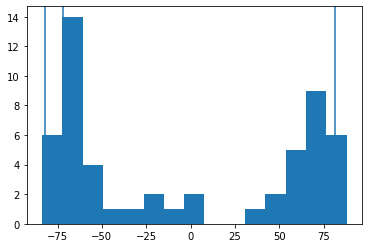

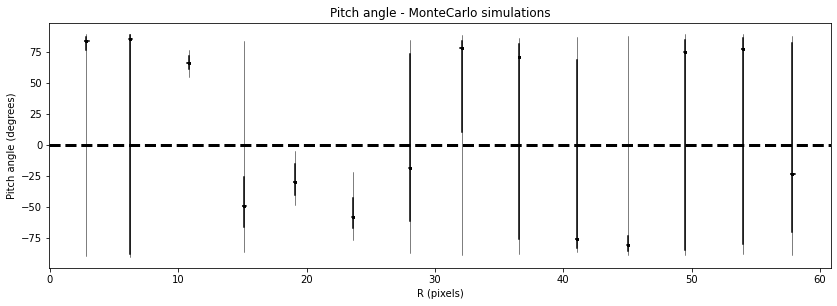

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.823411   2.718532   3.054681   2.893501   2.746180   3.038111   
1       1   6.249342   6.112607   6.488042   6.302993   6.215779   6.426008   
2       2  10.815076  10.586667  10.930994  10.853593  10.741591  10.891761   
3       3  15.138737  14.956044  15.303118  15.203498  15.058608  15.272933   
4       4  19.105235  18.966521  19.249292  19.163867  19.059156  19.209929   
5       5  23.630451  23.558646  23.717924  23.669996  23.592984  23.710418   
6       6  28.073873  27.939871  28.159688  28.119059  28.018457  28.157900   
7       7  32.069109  31.962322  32.179488  32.102347  32.015716  32.152500   
8       8  36.583794  36.523869  36.655593  36.618418  36.563076  36.639437   
9       9  41.046521  40.964429  41.136013  41.090191  41.010645  41.122141   
10     10  45.045301  44.949958  45.123661  45.091435  45.001954  45.110316   
11     11  49.507157  49.412470  49.604801  49.55482

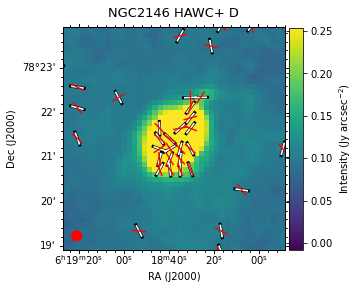

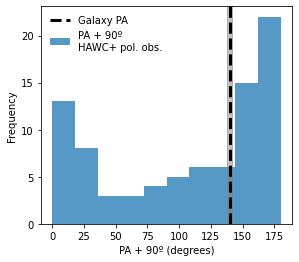

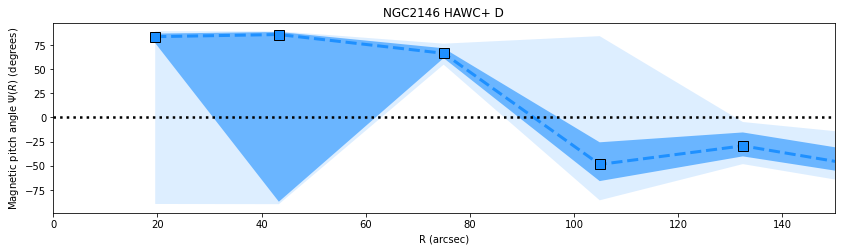

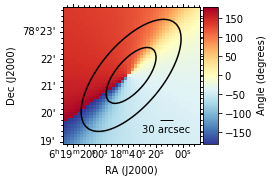

SNR pol limit is 0, switching to inf
34.70462653123258 38.85061789851986


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/80 [00:00<?, ?it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  3  7 11 15 19 23 27 31 35 39 43 47 51 55]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    1.989410   1.814949   2.120426   2.050585   1.919601   2.109547   
1    5.420371   5.279515   5.522066   5.478021   5.361823   5.510690   
2    9.236547   9.053687   9.379507   9.290924   9.165681   9.348231   
3   13.160043  12.985447  13.277323  13.202529  13.105769  13.259983   
4   17.128687  16.989571  17.281371  17.179820  17.060354  17.244482   
5   21.093203  20.982583  21.192978  21.135403  21.032702  21.170504   
6   25.084169  24.950781  25.206116  25.126315  25.029297  25.174179   
7   29.067459  28.951365  29.171957  29.124341  29.010083  29.162245   
8   33.065747  32.984568  33.140442  33.103362  33.024901  33.125904   
9   37.050989  36.978962  37.157939  37.088597  37.012850  37.131509   
10  41.033616  40.942587  41.130539  41.082392  40.992911  41.121762   
11  45.002757  44.890036  45.

/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 80/80 [00:01<00:00, 41.37it/s]


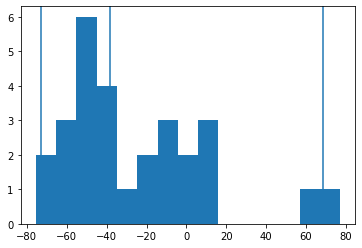

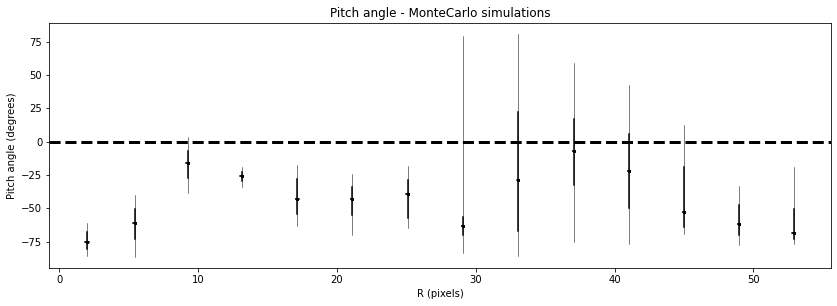

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   1.989410   1.814949   2.120426   2.050585   1.919601   2.109547   
1       1   5.420371   5.279515   5.522066   5.478021   5.361823   5.510690   
2       2   9.236547   9.053687   9.379507   9.290924   9.165681   9.348231   
3       3  13.160043  12.985447  13.277323  13.202529  13.105769  13.259983   
4       4  17.128687  16.989571  17.281371  17.179820  17.060354  17.244482   
5       5  21.093203  20.982583  21.192978  21.135403  21.032702  21.170504   
6       6  25.084169  24.950781  25.206116  25.126315  25.029297  25.174179   
7       7  29.067459  28.951365  29.171957  29.124341  29.010083  29.162245   
8       8  33.065747  32.984568  33.140442  33.103362  33.024901  33.125904   
9       9  37.050989  36.978962  37.157939  37.088597  37.012850  37.131509   
10     10  41.033616  40.942587  41.130539  41.082392  40.992911  41.121762   
11     11  45.002757  44.890036  45.093536  45.03538

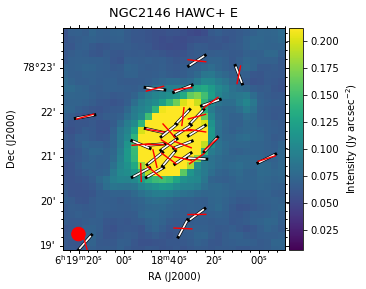

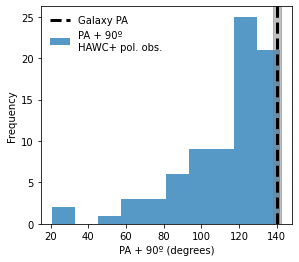

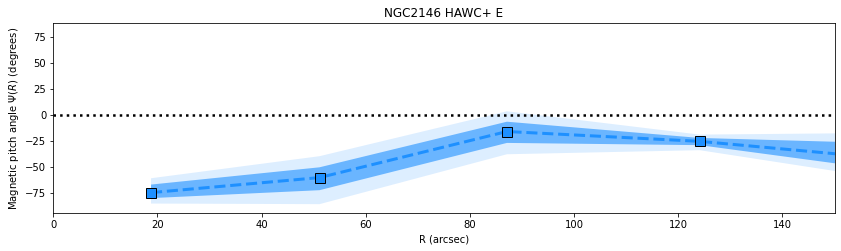

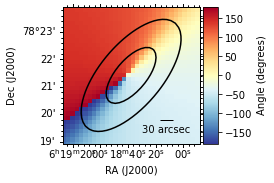

In [20]:
# NGC2146
source_center = ngc2146_center
PA = ngc2146_pa
dPA = ngc2146_dpa
incl = ngc2146_incl
dincl = ngc2146_dincl
nbins = 15

image_input=legacy_wd+"NGC2146_A.fits"
name="NGC2146_A_"
plot_title = r'NGC2146 HAWC+ A'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC2146_A"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


ngc2146_a_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=150)

image_input=legacy_wd+"NGC2146_C.fits"
name="NGC2146_C_"
plot_title = r'NGC2146 HAWC+ C'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC2146_C"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


ngc2146_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=150)

image_input=legacy_wd+"NGC2146_D.fits"
name="NGC2146_D_"
plot_title = r'NGC2146 HAWC+ D'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC2146_D"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

ngc2146_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit,
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=150)

image_input=legacy_wd+"NGC2146_E.fits"
name="NGC2146_E_"
plot_title = r'NGC2146 HAWC+ E'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC2146_E"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


ngc2146_e_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=150)


SNR pol limit is 0, switching to inf
42.93740850020471 41.60679914817206


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
100%|██████████| 19/19 [00:00<00:00, 124.69it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  3  6  9 12 16 19 22 25 28 32 35 38 41 44 48 51 54 57 60]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.123224   2.111054   2.149013   2.132373   2.117679   2.147277   
1    4.637547   4.540339   4.767484   4.704117   4.580608   4.729962   
2    7.596965   7.522339   7.698704   7.632480   7.556950   7.673082   
3   10.547575  10.478018  10.640110  10.577849  10.507278  10.618152   
4   14.093813  14.006044  14.201466  14.117473  14.062225  14.147111   
5   17.529521  17.461223  17.601739  17.554420  17.505787  17.590986   
6   20.518811  20.452343  20.593470  20.545781  20.491145  20.570705   
7   23.519520  23.460523  23.573027  23.544378  23.495418  23.562754   
8   26.515191  26.449459  26.567113  26.539108  26.489385  26.558707   
9   30.071401  30.006687  30.132899  30.097189  30.037753  30.122696   
10  33.500125  33.448081  33.550424  33.516969  33.482763  33.543377   
11  36.502703 


  0%|          | 0/86 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 5/86 [00:00<00:01, 41.10it/s]

Pitch angle model generated: NGC3627_D_pitch_model.fits
Pitch angle profile generated: NGC3627_D_profile.csv


100%|██████████| 86/86 [00:02<00:00, 40.89it/s]


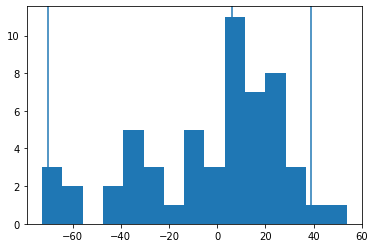

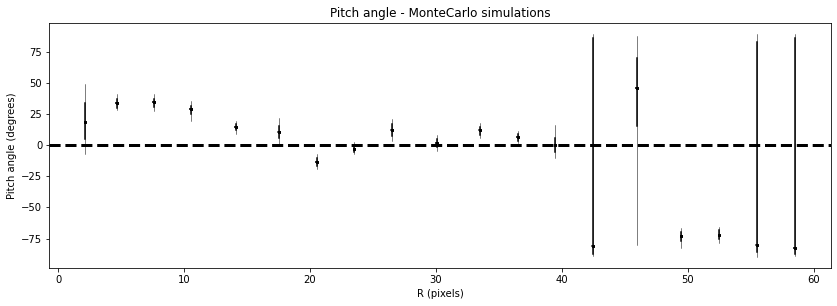

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.123224   2.111054   2.149013   2.132373   2.117679   2.147277   
1       1   4.637547   4.540339   4.767484   4.704117   4.580608   4.729962   
2       2   7.596965   7.522339   7.698704   7.632480   7.556950   7.673082   
3       3  10.547575  10.478018  10.640110  10.577849  10.507278  10.618152   
4       4  14.093813  14.006044  14.201466  14.117473  14.062225  14.147111   
5       5  17.529521  17.461223  17.601739  17.554420  17.505787  17.590986   
6       6  20.518811  20.452343  20.593470  20.545781  20.491145  20.570705   
7       7  23.519520  23.460523  23.573027  23.544378  23.495418  23.562754   
8       8  26.515191  26.449459  26.567113  26.539108  26.489385  26.558707   
9       9  30.071401  30.006687  30.132899  30.097189  30.037753  30.122696   
10     10  33.500125  33.448081  33.550424  33.516969  33.482763  33.543377   
11     11  36.502703  36.453852  36.550215  36.52384

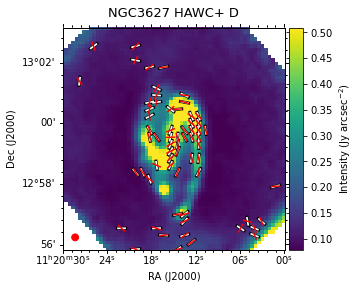

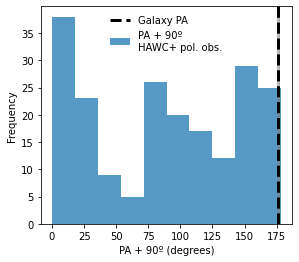

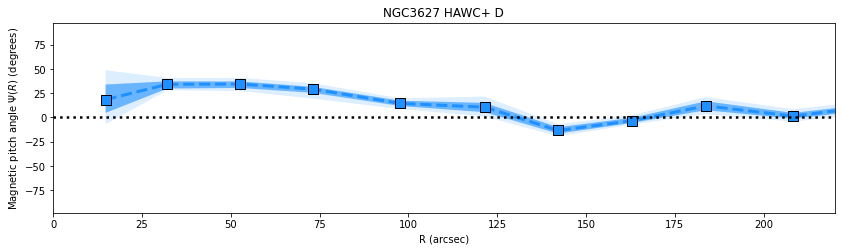

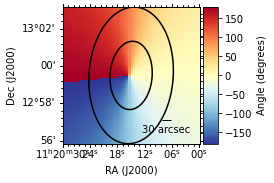

In [21]:
# NGC3627
source_center = ngc3627_center
PA = ngc3627_pa
dPA = ngc3627_dpa
incl = ngc3627_incl
dincl = ngc3627_dincl
nbins = 20

image_input=legacy_wd+"NGC3627_D.fits"
name="NGC3627_D_"
plot_title = r'NGC3627 HAWC+ D'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC3627"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])

ngc3627_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=220)

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
53.41604974580546 54.4509591452542


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 58%|█████▊    | 11/19 [00:00<00:00, 99.43it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76]


/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/108 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▎         | 4/108 [00:00<00:02, 38.02it/s]

            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.829080   2.674941   2.983323   2.859717   2.794630   2.955331   
1    6.404520   6.215645   6.500185   6.465042   6.324141   6.494364   
2   10.202145  10.054557  10.384193  10.279414  10.142196  10.331463   
3   14.147040  14.048933  14.232693  14.186017  14.094857  14.202037   
4   18.106039  18.042204  18.197190  18.145823  18.071304  18.185155   
5   22.085469  22.012915  22.157192  22.119360  22.057885  22.143500   
6   26.075304  25.993834  26.152514  26.111832  26.041973  26.145589   
7   30.065907  30.001378  30.172891  30.104926  30.031818  30.149489   
8   34.054818  33.974526  34.134252  34.089139  34.021093  34.115861   
9   38.053907  37.984568  38.119558  38.080199  38.025064  38.113337   
10  42.045246  41.982611  42.111991  42.078209  42.022683  42.098148   
11  46.041228  45.993901  46.112498  46.065660  46.013190  46.095047   
12  50.037434  49.981109  50.090932  50.059994  50.014142  50.08

100%|██████████| 108/108 [00:02<00:00, 40.02it/s]


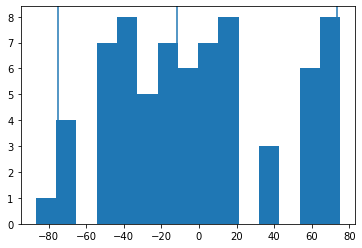

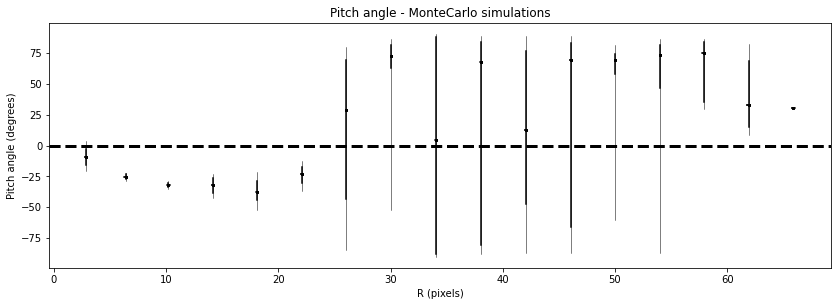

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.829080   2.674941   2.983323   2.859717   2.794630   2.955331   
1       1   6.404520   6.215645   6.500185   6.465042   6.324141   6.494364   
2       2  10.202145  10.054557  10.384193  10.279414  10.142196  10.331463   
3       3  14.147040  14.048933  14.232693  14.186017  14.094857  14.202037   
4       4  18.106039  18.042204  18.197190  18.145823  18.071304  18.185155   
5       5  22.085469  22.012915  22.157192  22.119360  22.057885  22.143500   
6       6  26.075304  25.993834  26.152514  26.111832  26.041973  26.145589   
7       7  30.065907  30.001378  30.172891  30.104926  30.031818  30.149489   
8       8  34.054818  33.974526  34.134252  34.089139  34.021093  34.115861   
9       9  38.053907  37.984568  38.119558  38.080199  38.025064  38.113337   
10     10  42.045246  41.982611  42.111991  42.078209  42.022683  42.098148   
11     11  46.041228  45.993901  46.112498  46.06566

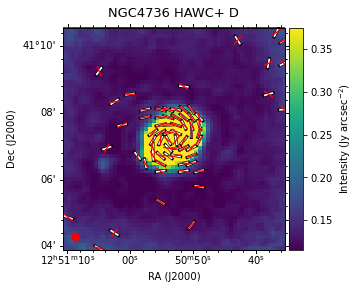

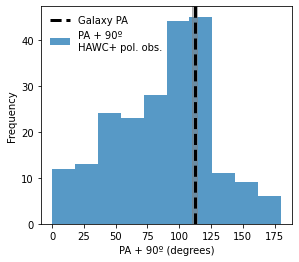

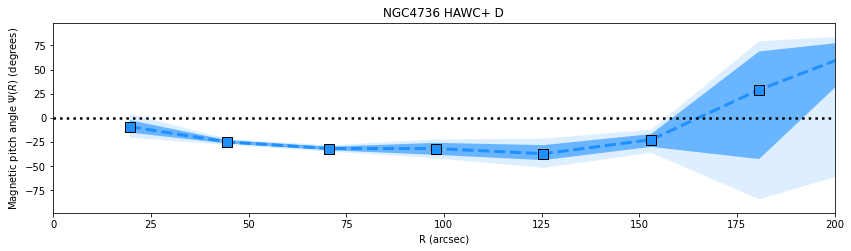

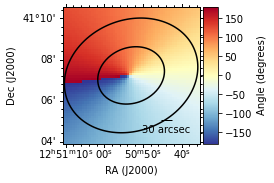

In [22]:
# NGC4736
source_center = ngc4736_center
PA = ngc4736_pa
dPA = ngc4736_dpa
incl = ngc4736_incl
dincl = ngc4736_dincl
nbins = 20

image_input=legacy_wd+"NGC4736_D.fits"
name="NGC4736_D_"
plot_title = r'NGC4736 HAWC+ D'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC4736"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])


ngc4736_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=200)

SNR pol limit is 0, switching to inf
61.055856267088046 60.011073758395256


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 53%|█████▎    | 10/19 [00:00<00:00, 87.79it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  4  9 13 18 22 27 31 36 41 45 50 54 59 63 68 72 77 82 86]


/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/121 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  3%|▎         | 4/121 [00:00<00:03, 36.98it/s]

            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.831093   2.673968   2.937168   2.852210   2.792146   2.885452   
1    7.096461   6.883589   7.181913   7.143976   7.003128   7.166440   
2   11.181318  11.101026  11.293691  11.251745  11.129180  11.284179   
3   15.738819  15.644909  15.817103  15.765627  15.690666  15.792161   
4   20.102598  20.021923  20.168714  20.134181  20.062883  20.155250   
5   24.605795  24.539313  24.679483  24.642332  24.580520  24.663931   
6   29.085095  29.003308  29.147994  29.119238  29.053476  29.140710   
7   33.615673  33.554592  33.672036  33.638727  33.598401  33.667425   
8   38.589188  38.550996  38.637185  38.613468  38.569494  38.626310   
9   43.045730  42.993867  43.096795  43.067586  43.021122  43.087019   
10  47.556090  47.508021  47.622514  47.580163  47.528241  47.611714   
11  52.039106  51.982239  52.113230  52.067328  52.016082  52.097277   
12  56.554478  56.510380  56.608633  56.584599  56.533439  56.60

100%|██████████| 121/121 [00:02<00:00, 40.50it/s]


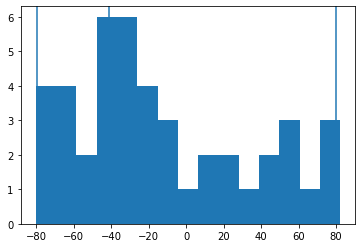

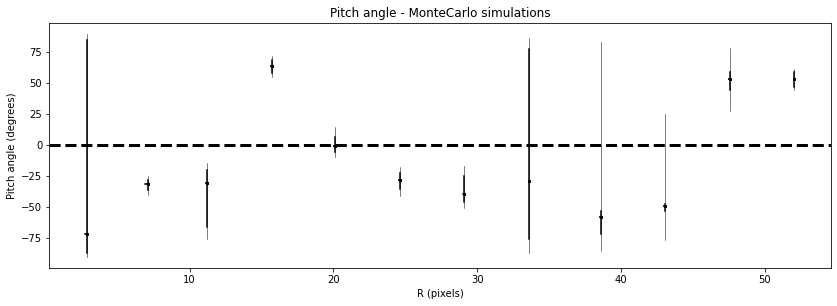

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.831093   2.673968   2.937168   2.852210   2.792146   2.885452   
1       1   7.096461   6.883589   7.181913   7.143976   7.003128   7.166440   
2       2  11.181318  11.101026  11.293691  11.251745  11.129180  11.284179   
3       3  15.738819  15.644909  15.817103  15.765627  15.690666  15.792161   
4       4  20.102598  20.021923  20.168714  20.134181  20.062883  20.155250   
5       5  24.605795  24.539313  24.679483  24.642332  24.580520  24.663931   
6       6  29.085095  29.003308  29.147994  29.119238  29.053476  29.140710   
7       7  33.615673  33.554592  33.672036  33.638727  33.598401  33.667425   
8       8  38.589188  38.550996  38.637185  38.613468  38.569494  38.626310   
9       9  43.045730  42.993867  43.096795  43.067586  43.021122  43.087019   
10     10  47.556090  47.508021  47.622514  47.580163  47.528241  47.611714   
11     11  52.039106  51.982239  52.113230  52.06732

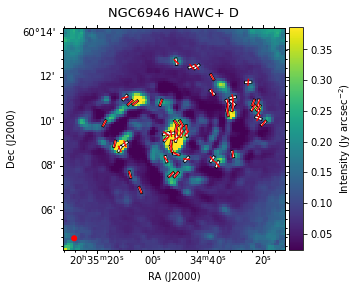

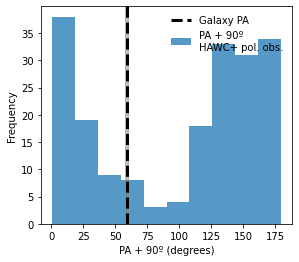

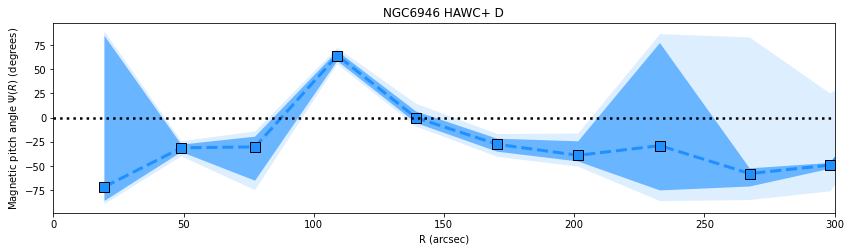

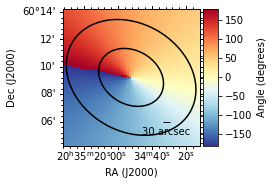

In [23]:
# NGC6946
source_center = ngc6946_center
PA = ngc6946_pa
dPA = ngc6946_dpa
incl = ngc6946_incl
dincl = ngc6946_dincl
nbins = 20

image_input=legacy_wd+"NGC6946_D.fits"
name="NGC6946_D_"
plot_title = r'NGC6946 HAWC+ D'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC6946"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])



ngc6946_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit,
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=300)

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]

SNR pol limit is 0, switching to inf
60.580761209844106 57.65256514693928


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 58%|█████▊    | 11/19 [00:00<00:00, 109.40it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:00<00:00, 99.80it/s] 

Simulations done, generating profile from cube
Bin limits: 
[ 0  4  8 13 17 21 26 30 34 39 43 47 52 56 60 65 69 74 78 82]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.817206   2.394044   3.186231   2.974560   2.716159   3.119694   
1    6.313628   5.869834   6.605354   6.426443   6.238845   6.533404   
2   10.791302  10.526437  10.990920  10.898418  10.701352  10.952550   
3   15.144292  14.971614  15.422431  15.216692  15.044192  15.277391   
4   19.106949  18.955910  19.268690  19.182346  19.046621  19.239682   
5   23.629930  23.408915  23.795183  23.685431  23.570107  23.740923   
6   28.068966  27.936234  28.202436  28.124292  28.013076  28.174943   
7   32.070615  31.940741  32.216446  32.122196  32.004925  32.182753   
8   36.588411  36.430959  36.707956  36.651704  36.532833  36.686075   
9   41.046244  40.946989  41.163388  41.104411  41.003113  41.144795   
10  45.040705  44.951108  45.163154  45.081924  45.000779  45.123481   
11  49.564242 


  0%|          | 0/115 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▍         | 5/115 [00:00<00:02, 41.01it/s]

Pitch angle model generated: NGC4826_C_pitch_model.fits
Pitch angle profile generated: NGC4826_C_profile.csv


100%|██████████| 115/115 [00:02<00:00, 41.50it/s]


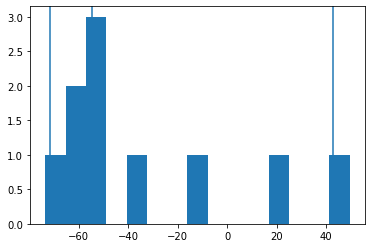

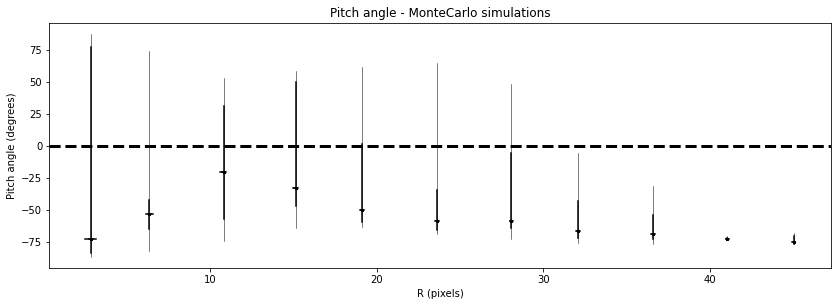

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.817206   2.394044   3.186231   2.974560   2.716159   3.119694   
1       1   6.313628   5.869834   6.605354   6.426443   6.238845   6.533404   
2       2  10.791302  10.526437  10.990920  10.898418  10.701352  10.952550   
3       3  15.144292  14.971614  15.422431  15.216692  15.044192  15.277391   
4       4  19.106949  18.955910  19.268690  19.182346  19.046621  19.239682   
5       5  23.629930  23.408915  23.795183  23.685431  23.570107  23.740923   
6       6  28.068966  27.936234  28.202436  28.124292  28.013076  28.174943   
7       7  32.070615  31.940741  32.216446  32.122196  32.004925  32.182753   
8       8  36.588411  36.430959  36.707956  36.651704  36.532833  36.686075   
9       9  41.046244  40.946989  41.163388  41.104411  41.003113  41.144795   
10     10  45.040705  44.951108  45.163154  45.081924  45.000779  45.123481   

     R_s2down      pitch  pitch_s1up  pitch_s1down 

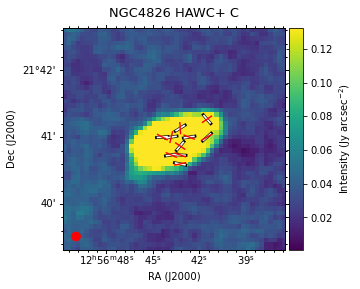

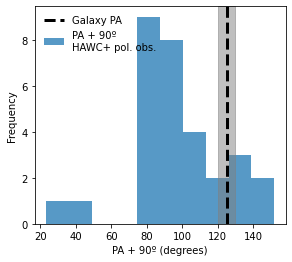

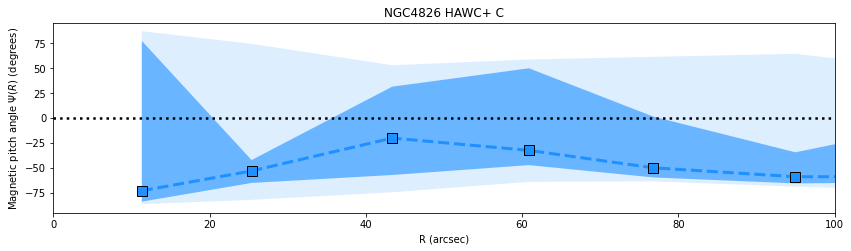

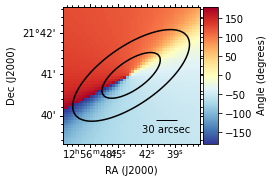

In [24]:
# NGC4826
source_center = ngc4826_center
PA = ngc4826_pa
dPA = ngc4826_dpa
incl = ngc4826_incl
dincl = ngc4826_dincl
nbins = 20

image_input=legacy_wd+"NGC4826_C.fits"
name="NGC4826_C_"
plot_title = r'NGC4826 HAWC+ C'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC4826"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])



ngc4826_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit,
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

SNR pol limit is 0, switching to inf
45.54440192342832 46.64760594282438


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:895: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/100 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:652: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
100%|██████████| 19/19 [00:00<00:00, 136.69it/s]

Simulations done, generating profile from cube
Bin limits: 
[ 0  3  6 10 13 17 20 24 27 31 34 38 41 45 48 52 55 59 62 66]
            R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0    2.271439   1.797028   2.646533   2.480318   1.914009   2.628217   
1    4.913445   4.483018   5.377418   5.145766   4.682770   5.328672   
2    8.238060   7.989082   8.746949   8.413113   8.114298   8.561244   
3   11.556447  11.309144  12.008400  11.812308  11.428953  11.930027   
4   15.099167  14.865160  15.370996  15.229138  14.986513  15.321365   
5   18.531143  18.251248  18.886669  18.690272  18.387817  18.812007   
6   22.098658  21.844548  22.343437  22.192728  21.993420  22.283398   
7   25.525022  25.096972  25.718466  25.632588  25.443614  25.714517   
8   29.082761  28.882828  29.310547  29.180356  28.983310  29.231741   
9   32.520457  32.323703  32.752367  32.638081  32.447147  32.707924   
10  36.050367  35.876309  36.274845  36.155186  35.968243  36.232709   
11  39.536229 


  0%|          | 0/94 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
 15%|█▍        | 14/94 [00:00<00:01, 40.31it/s]

Pitch angle model generated: NGC7331_D_pitch_model.fits
Pitch angle profile generated: NGC7331_D_profile.csv


100%|██████████| 94/94 [00:02<00:00, 40.30it/s]


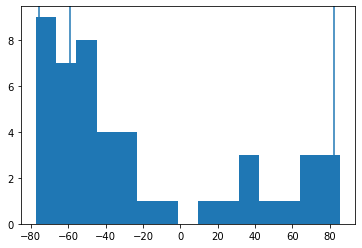

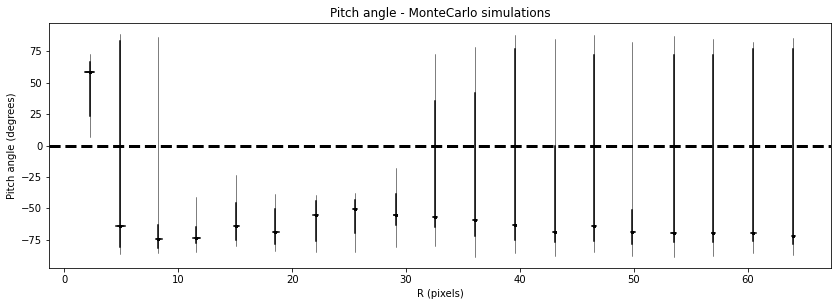

    index          R      R_min      R_max     R_s1up   R_s1down     R_s2up  \
0       0   2.271439   1.797028   2.646533   2.480318   1.914009   2.628217   
1       1   4.913445   4.483018   5.377418   5.145766   4.682770   5.328672   
2       2   8.238060   7.989082   8.746949   8.413113   8.114298   8.561244   
3       3  11.556447  11.309144  12.008400  11.812308  11.428953  11.930027   
4       4  15.099167  14.865160  15.370996  15.229138  14.986513  15.321365   
5       5  18.531143  18.251248  18.886669  18.690272  18.387817  18.812007   
6       6  22.098658  21.844548  22.343437  22.192728  21.993420  22.283398   
7       7  25.525022  25.096972  25.718466  25.632588  25.443614  25.714517   
8       8  29.082761  28.882828  29.310547  29.180356  28.983310  29.231741   
9       9  32.520457  32.323703  32.752367  32.638081  32.447147  32.707924   
10     10  36.050367  35.876309  36.274845  36.155186  35.968243  36.232709   
11     11  39.536229  39.330593  39.693313  39.63944

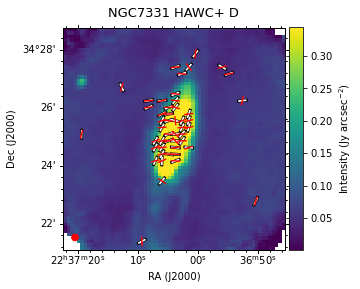

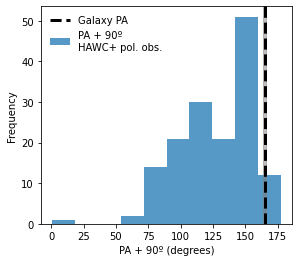

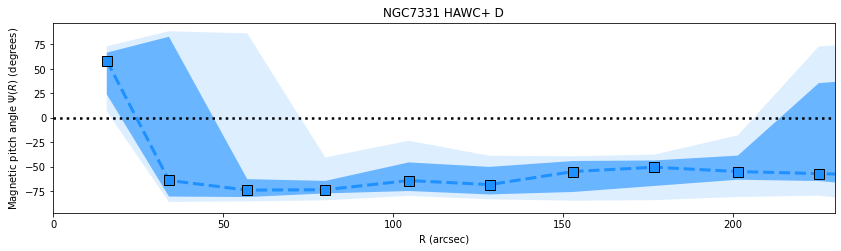

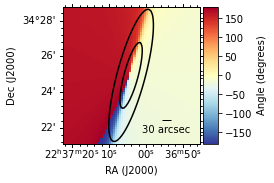

In [25]:
# NGC7331
image_input=legacy_wd+"NGC7331_D.fits"
name="NGC7331_D_"
source_center = ngc7331_center
PA = ngc7331_pa
dPA = ngc7331_dpa
incl = ngc7331_incl
dincl = ngc7331_dincl
nbins = 20
plot_title = r'NGC7331 HAWC+ D'

# SNR limits have to be read from the galaxies.lst file in the DB 
name_SNR = "NGC7331"
SNR_polflux_limit = np.array(SNR_galaxies["SNRpi_cut"][SNR_galaxies["object"]==name_SNR])
p_limit = np.array(SNR_galaxies["p_cut"][SNR_galaxies["object"]==name_SNR])
SNR_int_limit = np.array(SNR_galaxies["SNRI_cut"][SNR_galaxies["object"]==name_SNR])
SNR_pol_limit = np.array(SNR_galaxies["SNRp_cut"][SNR_galaxies["object"]==name_SNR])



ngc7331_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=230)

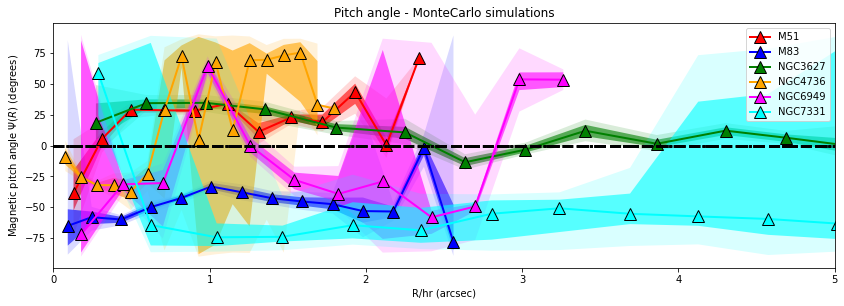

In [26]:
# Combined pitch angle plot 

profile_list = [m51_profile[0], m83_d_profile[0], ngc3627_d_profile[0],
                ngc4736_d_profile[0], ngc6946_d_profile[0], ngc7331_d_profile[0]]

hr_list = [hr_M51, hr_M83, hr_NGC3627, hr_NGC4736, hr_NGC6946, hr_NGC7331]

pixscale_list = [get_pixscale(legacy_wd+"M51_D.fits"),
                 get_pixscale(legacy_wd+"M83_D.fits"),
                 get_pixscale(legacy_wd+"NGC3627_D.fits"),
                 get_pixscale(legacy_wd+"NGC4736_D.fits"),
                 get_pixscale(legacy_wd+"NGC6946_D.fits"),
                 get_pixscale(legacy_wd+"NGC7331_D.fits")]

profile_color_list = ["red","blue","green","orange","magenta","cyan"]
profile_linestyle_list = ["-","-","-","-","-","-"]
profile_linewidth_list = [2,2,2,2,2,2]
profile_label_list=["M51", "M83", "NGC3627", "NGC4736", "NGC6949", "NGC7331"]
profile_marker = "^"
profile_markersize=12
fig, ax = plt.subplots(figsize=(14,4.5))
    
for profile, pixscale, profile_color, profile_linestyle, profile_linewidth, profile_label, hr in zip(profile_list, pixscale_list,
                                                               profile_color_list, profile_linestyle_list,
                                                            profile_linewidth_list, profile_label_list, hr_list):
    ax.plot(profile["R"]*pixscale/hr, profile["pitch"], color=profile_color, linestyle=profile_linestyle,
            linewidth=profile_linewidth, label=profile_label, marker=profile_marker, markerfacecolor=profile_color,
            markersize=profile_markersize, markeredgecolor="black")
    ax.fill_between(profile["R"]*pixscale/hr, profile["pitch_s1up"], profile["pitch_s1down"],
                    where=(profile["pitch_s1up"] > profile["pitch_s1down"]), facecolor=profile_color,
                    alpha=0.6, label="")
    ax.fill_between(profile["R"]*pixscale/hr, profile["pitch_s2up"], profile["pitch_s2down"],
                    where=(profile["pitch_s2up"] > profile["pitch_s2down"]), facecolor=profile_color,
                    alpha=0.15, label="")
    plt.axhline(0, linewidth=2.5, linestyle=":", color="black")

plt.legend()
ax.set_xlabel("R/hr (arcsec)")
ax.set_ylabel("Magnetic pitch angle $\Psi(R)$ (degrees)")
ax.set_xlim(0,5)
plt.axhline(y=0., color='black', linestyle='--', linewidth=3)
plt.title("Pitch angle - MonteCarlo simulations") 
plt.savefig("plot_magpitch_hr_DR1.png")

In [27]:
hr_list

[84.203, 106.752, 53.954, 253.87, 110.4790756634583, 54.6]

In [28]:
m51_profile[0]

,index,R,R_min,R_max,R_s1up,R_s1down,R_s2up,R_s2down,pitch,pitch_s1up,pitch_s1down,pitch_s2up,pitch_s2down,npix
0,0,1.580464,1.509403,1.680046,1.608271,1.548169,1.640681,1.520974,-38.433622,-19.891677,-52.517588,5.108591,-72.579849,5.00
1,1,3.803517,3.717261,3.956641,3.842947,3.755553,3.910197,3.725516,5.436294,11.550437,-0.457532,19.571615,-5.806879,34.43
2,2,6.052396,5.988011,6.214604,6.092942,6.023376,6.209175,5.995445,28.977514,31.823741,26.566735,34.435435,21.802202,40.01
3,3,8.621103,8.582055,8.708824,8.678396,8.598174,8.701755,8.587225,28.514150,30.026188,26.704317,32.233243,25.103115,88.90
4,4,11.040211,10.993538,11.162979,11.114731,11.008730,11.151017,10.998443,28.179811,29.690440,26.963515,31.031197,24.911065,59.80
5,5,13.606360,13.522144,13.667956,13.635254,13.573198,13.658235,13.549187,33.740989,35.405172,31.909564,37.516561,30.569613,69.25
6,6,16.027493,15.977304,16.120891,16.061542,16.007583,16.098665,15.982053,11.104542,18.044794,5.299678,29.241788,1.299457,33.97
7,7,18.588033,18.526665,18.641247,18.606328,18.567888,18.621758,18.538234,22.728076,25.135390,20.141898,27.700966,17.325556,62.85
8,8,21.022901,20.976177,21.103647,21.062845,21.001501,21.084792,20.984729,18.999201,24.999278,14.565810,30.873074,11.671522,34.31
9,9,23.574352,23.517458,23.630225,23.596945,23.549801,23.620294,23.519538,43.231029,49.986992,33.642252,55.937114,25.638859,15.75


In [29]:
SNR_polflux_limit

array([3.])